## <center>Processamento de Linguagem Natural em Textos de Mídias Sociais: Fundamentos, Ferramentas e Aplicações</center>

### <center>XXVIII Simpósio Brasileiro de Sistemas Multimídia e Web (WebMedia 2022)</center>

<br></br>

<center>Frances A. Santos (UNICAMP), Jordan Kobellarz (UTFPR), Fábio R. de Souza (USP), Leandro A. Villas (UNICAMP), Thiago H. Silva (UTFPR)</center>

<br></br>

<center>Curitiba, PR</center>
<center>07 de Novembro de 2022</center>

| <a href="https://colab.research.google.com/github/webmedia2022-nlp/course-code/blob/main/NLP_WebMedia2022.ipynb" target="_parent"><img style="float: center;" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir no Colab"/></a> | <img style="float: center;" src="https://img.shields.io/badge/python-v3.8.13-blue" alt="Python Version"/> |
| --- | --- |

In [1]:
!pip install --no-cache-dir -r requirements.txt
!python -m spacy download en_core_web_sm #Instalando dependências específicas do spacy

2022-11-02 17:03:27.658977: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-02 17:03:27.659065: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 17:03:27.659358: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1660 Ti computeCapability: 7.5
coreClock: 1.59GHz coreCount: 24 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 268.26GiB/s
2022-11-02 17:03:27.659443: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2022-11-02 17:03:27.659475: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynami

In [23]:
%load_ext autoreload
%autoreload 2

import math
import warnings
import pathlib
import os 
import getpass
import pandas as pd
import numpy as np
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import getpass
import warnings
import pathlib
import os 
import json
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path

# Criação do diretório "data/"
Path("data").mkdir(parents=True, exist_ok=True)

from DataExtraction import DataExtraction
from Preprocessing import Preprocessing
from TextRepresentation import statisticalModels, SentenceEmbeddings, WordEmbeddings
from KnowledgeExtraction import Clustering, SemanticComprehension, SentimentAnalysis

warnings.filterwarnings('ignore')
tqdm.pandas()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Download de arquivos usados por bibliotecas
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jordan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Agenda

<img src="figs/agenda.png" style="float: center; zoom:100%;" />

# <center>Introdução</center>

### Por que mídias sociais?

Mídias sociais são acessadas por aproximadamente 4,7 bilhões de usuários em todo o planeta (i.e., 59% da população) [Kemp 2022]

<img src="figs/social-media.jpeg" style="float: center; zoom:100%;" />

### Exemplo (Twitter):

* 200 Bilhões de postagens por ano
* equivalente a 6 mil postagens por segundo

Fonte: [Twitter Usage Statistics](https://www.internetlivestats.com/twitter-statistics)

### Possibilidades para acessar dados públicos em larga escala

* **Twitter** - API (stream e histórico)
* **Reddit** - API (stream e histórico)
* **Meta (Instagram e Facebook)** - Plataforma CrowdTangle
* **Swarm (Forsquare)** - API
* **Flickr** - API
* **Google Places** - API

### Valiosa fonte de dados para diversas aplicações

* **Na Academia**
    * Análise de fenômenos sociais
    * Sensoriamento social
    * Detecção de notícias falsas
    * Discurso de ódio
    * Polarização política

* **Na Indústria**
    * Benchmarking (comparação com concorrentes)
    * Forecasting (análise de tendências)
    * Sistemas de recomendação
    * Personalização / customização em larga escala
    * Análise de risco

### Por que textos?

Textos escritos em linguagem natural, <br>estão presentes na maioria dos dados disponíveis de mídias sociais

<img src="figs/social-media-content.png" style="float: right; zoom:80%;" />


# <center>1. Textos de mídias sociais <br>Suas principais características e como coletá-los</center>

### Onde encontrar dados textuais?

* Postagens
* Artigos
* Mensagens / comentários
* Metainformações de páginas, imagens, videos, perfis, postagens, mensagens, etc. 
* Extração de texto em imagem, áudio e video

### Mídias sociais consideradas


| <img src="figs/twitter.png" style="float: center; zoom:20%;" /> | <img src="figs/reddit.png" style="float: top center; zoom:50%;" /> | <img src="figs/facebook.png" style="float: center; zoom:40%;" /> |
| --- | --- | --- |


## 1.1 Twitter

* Mídia social de *Microblogging*
* Mensagens limitadas a 280 caracteres
* Uma das primeiras redes a disponibilizar uma API para extração de dados públicos em larga escala
* Possibilidade de coleta de dados históricos ou em tempo real (*streaming*)
* Qualquer dado público pode ser acessado, exceto os de perfis privados (menos de 10%)

### Característica proeminente

Simplicidade nas interações e dicionário de dados:

* tweets
* hashtags #
* menções @
* retweets RT
* respostas

### Dados que podem ser obtidos via API

* **texto do tweet**
* **timestamp**
* **autor**
    * nome
    * localização
    * se é verificado
    * quantidade de seguidores, amigos, postagens
    * data de criação da conta
    * língua do perfil
    * etc.
* **geolocalização do tweet (GeoJson)**
    * adicionada explícitamente
    * ou capturada do dispositivo que gerou o tweet
* **entidades**
    * hashtags
    * links
    * menções
    * mídias
* **sinais sociais**
    * quantidade de retweets
    * quantidade de curtidas
    * quantidade de respostas
* etc. 

Conheça o [dicionário completo de dados de um tweet aqui](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet). 

### Exemplo de um tweet

Alguns campos foram omitidos para facilitar a visualização. 

```json
{
  "created_at": "Thu Apr 06 15:24:15 +0000 2017",
  "id_str": "850006245121695744",
  "text": "1\/ Today we\u2019re sharing our vision for the future of the Twitter API platform!\nhttps:\/\/t.co\/XweGngmxlP",
  "user": {
    "id": 2244994945,
    "name": "Twitter Dev",
    "screen_name": "TwitterDev",
    "location": "Internet",
    "url": "https:\/\/dev.twitter.com\/",
    "description": "Your official source for Twitter Platform news, updates & events. Need technical help? Visit https:\/\/twittercommunity.com\/ \u2328\ufe0f #TapIntoTwitter"
  },
  "place": {   
  },
  "entities": {
    "hashtags": [      
    ],
    "urls": [
    ],
    "user_mentions": [     
    ]
  }
}
```

### Limitações e desafios

* Limite de 280 caracteres
    * restringe capacidade argumentativa
    * usuários contornam com uso de contrações de palavras, gírias da internet e emojis
* Representatividade da população
    * pode não representar bem o usuário médio de Internet
    * [tendem a ser usadas por pessoas mais jovens, com maior renda e grau de escolaridade](https://blogs.oii.ox.ac.uk/policy/did-you-consider-twitters-lack-of-representativeness-before-doing-that-predictive-study/)
* Representatividade do retorno da API
    * a API de streaming se baseia na [**relevância** e não **completude** dos dados](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/overview)
* Alta incidência de contas robô

### Coletando Tweets

- Utilizaremos a Twitter API v2 para coletar os tweets 
- Acesse a [página de desenvolverdores](https://developer.twitter.com/) e obtenha suas credenciais de acesso
- Limitamos cada coleta a **10 tweets**, mas todo o conteúdo dos tweets é adicionado (*appending*) ao arquivo local data/tweets.json
- Além dos campos *id* e *text* que estão presentes nos tweets por padrão, também solicitamos os campos *created_at, entities, geo, lang, public_metrics, source*. Para ver a lista completa de campos possíveis, acesse esta [página](https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet)
- Filtramos para selecionar apenas os tweets escritos em Inglês ( *lang = "en"* ) e que contenham o termo "nyc", que referencia a cidade de Nova Iorque
- Após coletar os tweets, extraímos os valores dos campos *text, timestamp_ms, ...* e retornamos no formato Pandas DataFrame. 

In [5]:
# Credenciais da API do Twitter

print("Informe seu 'API KEY'")
twitter_consumer_key = getpass.getpass()

print("Informe seu 'API KEY SECRET'")
twitter_consumer_secret = getpass.getpass()

print("Informe seu 'ACCESS TOKEN KEY'")
twitter_access_token_key = getpass.getpass()

print("Informe seu 'ACCESS TOKEN SECRET'")
twitter_access_token_secret = getpass.getpass()

print("Informe seu 'Bearer TOKEN'")
twitter_bearer_token = getpass.getpass()

Informe seu 'API KEY'
········
Informe seu 'API KEY SECRET'
········
Informe seu 'ACCESS TOKEN KEY'
········
Informe seu 'ACCESS TOKEN SECRET'
········
Informe seu 'Bearer TOKEN'
········


In [17]:
## Coleta de tweets
try:
    df_tweets = DataExtraction().twitter(
        twitter_consumer_key, 
        twitter_consumer_secret, 
        twitter_access_token_key, 
        twitter_access_token_secret, 
        twitter_bearer_token
    )
except:
    ## Caso aconteça algum erro durante a coleta, é carregado o arquivo existente
    with open("data/tweets.json", "r") as tweet_file:
        tweets = json.load(tweet_file)
        data = [{
                "created_at": item["created_at"],
                "url": "https://twitter.com/anyuser/status/" + item["id"],
                "score": item["public_metrics"]["like_count"],
                "text": item["text"],
                "length":len(item["text"]),
                "geo": item["geo"]
                } for item in tweets]
        df_tweets = pd.DataFrame(data)
    
df_tweets.head()

,created_at,url,score,text,length,geo
0,2022-11-01T19:38:01.000Z,https://twitter.com/anyuser/status/15875294130...,0,NY. Every corner this past Sunday … https://t....,83,{}
1,2022-11-01T19:38:00.000Z,https://twitter.com/anyuser/status/15875294087...,0,@AdrienneMaloof \n\nhttps://t.co/UUDW1wlARR\n\...,241,{}
2,2022-11-01T19:38:03.000Z,https://twitter.com/anyuser/status/15875294203...,0,RT @nymetrowx: Daylight saving time ends this ...,124,{}
3,2022-11-01T19:38:03.000Z,https://twitter.com/anyuser/status/15875294217...,0,RT @YB_2: The NYC transparency law goes into e...,121,{}
4,2022-11-01T19:38:03.000Z,https://twitter.com/anyuser/status/15875294210...,0,Tune in to the @DistrictingNYC Public Meeting ...,132,{}


## 1.2 Reddit

* Mídia social baseada em fóruns de discussão
* Comunidades/fóruns → \subreddits
* Mais de 100K comunidades e 50 mi de usuários ativos diariamente em [2020](https://www.redditinc.com/advertising/audience)

### Características proeminentes

* Sistema de moderação autoorganizável
    * \subreddits possuem regras próprias criadas pelos moderadores e membros
    * algumas comunidades possuem alto nível de comprometimento com as regras propostas
    * mecanismos de recompensa para colaboradores ativos
* Possibilidade de coletar dados em stream e histórico
    * vantagem de permitir a recuperação do histórico completo
* Permite acesso à qualquer informação disponível publicamente
    * inclui postagens, comentários, perfis, comunidades e suas respectivas metainformações

### Dados que podem ser obtidos via API

**[submission (postagem)](https://praw.readthedocs.io/en/stable/code_overview/models/comment.html)**
* id
* url
* permalink
* created_utc
* title
* selftext (conteúdo da postagem)
* score (número de upvotes)
* [author](https://praw.readthedocs.io/en/stable/code_overview/models/comment.html) (Redditor)
    * name
    * created_utc
    * comment_karma (pontuação do usuário)
    * has_verified_email
    * etc.
* [comments](https://praw.readthedocs.io/en/stable/code_overview/models/comment.html) (árvore de comentários -- necessário percorrer com método específico para isso)
    * author (Redditor)
    * body
    * distinguished
    * etc.
* distinguished (se a postagem foi destacada pelo moderador)
* edited (se a postagem foi editada)
* is_original_content (se foi marcada automaticamente como conteúdo original)
* over_18 (se é conteúdo para maiores de 18 anos)
* etc.

### Limitações e desafios

* a plataforma permite um alto grau de anonimidade
    * é encorajado o uso de pseudônimo
    * é possível fazer cadastro sem verificação
    * abertura para comportamentos anti-éticos em comunidades não moderadas / permissivas
* cada comunidade possui regras próprias
    * práticas de moderação distintas
    * dificultando a comparação 
* liberdade no formato
    * campo aberto com possibiidade de uso de html e markdown
* alta incidência de bots
    * criam, fazem a curadoria e moderam conteúdos 

### Coletando Posts de \subreddits

- Utilizaremos a [API do Reddit](https://www.reddit.com/dev/api) para coletar posts
- Você deverá criar uma conta para acessar a API em [reddit.com](https://reddit.com)
- Depois de criar a conta, obtenha os Client ID e o Client Secret
- No exemplo a seguir, coletamos os top 100 posts de 5 subreddits, contendo o texto, url, número de comentários, data de criação e score (número de upvotes do post)
- Os dados são salvos no arquivo local data/reddit_posts.csv

In [ ]:
# Credenciais da API do Reddit

print("Informe seu 'CLIENT ID'")
REDDIT_CLIENT_ID = getpass.getpass()

print("Informe seu 'CLIENT SECRET'")
REDDIT_CLIENT_SECRET = getpass.getpass()

In [ ]:
# Subreddits com discussões sérias sobre assuntos como política, história e ciência.
subreddits = [
    'politics',
    'AskHistorians',
    'changemyview',
    'COVID19',
    'EverythingScience',
    'science'
]

# Coleta os top 100 posts de cada Subreddit
df_reddit_posts = DataExtraction().reddit(
    REDDIT_CLIENT_ID,
    REDDIT_CLIENT_SECRET,
    subreddits=subreddits,
    top_n=100
)

In [ ]:
# Apresenta alguns posts com texto
df_reddit_posts[df_reddit_posts['length'] > 0].tail(5)

## 1.3 Facebook (Meta)

### Características proeminentes

* Alto grau de controle de privacidade
* O anonimato é desencorajado 

### Formas de obter dados

* Via API nativa (limitada)
* Via web scraping (desencorajado)
* Via polls com usuários (não escalável)
* Via programa [Social Science One](https://socialscience.one/grant-process) (acesso direto à base do Facebook | difícil acesso | apenas para uso acadêmico)
* Via plataforma do [CrowdTangle](https://crowdtangle.com) (dados limitados a páginas e grupos famosos)

### [CrowdTangle](https://crowdtangle.com)

* Iniciativa da Meta criada para jornalistas, agências de checagem de fatos, profissionais de marketing e pesquisadores
* Possibilidade de consultar e visualizar dados em tempo real pela interface (dashboards)
* Mesmos dados apresentados na interface podem ser obtidos via API

* Informações que **podem** ser coletadas:
     * quando algo foi postado
     * tipo do post (video, imagem, texto)
     * página, conta ou grupo onde o conteúdo foi postado
     * quantidade de interações (likes, reações, comentários, compartilhamentos, visualizações de videos)
     * páginas públicas ou contas que compartilharam o conteúdo

* Informações que **não podem** ser coletadas:
    * alcance ou impressões de um post
    * conteúdos efêmeros, como stories, por exemplo
    * informações demográficas de usuários

* A base de dados disponível se limita a:
    * contas famosas (aprox. ~7 mi de páginas, grupos ou perfis verificados em 08/06/2021), incluindo:
        * páginas públicas com mais de 50K curtidas
        * grupos públicos com mais de 95K membros
        * grupos públicos dos Estados Unidos com mais de 2K membros
        * todos os perfis verificados

### Exemplo de retorno da API do CrowdTangle

```json
{
    "status": 200,
    "result": {
        "posts": [
            {
                "platformId": "47657117525_10154014482272526",
                "platform": "Facebook",
                "date": "2016-02-12 23:38:14",
                "updated": "2020-08-23 05:48:22",
                "type": "live_video_complete",
                "message": "Draymond at Foot Locker for #NBAAllStarTO with a special shoutout to #DubNation.",
                "expandedLinks": [
                    {
                        "original": "https://www.facebook.com/warriors/videos/10154014482272526/",
                        "expanded": "https://www.facebook.com/warriors/videos/10154014482272526/"
                    }
                ],
                "link": "https://www.facebook.com/warriors/videos/10154014482272526/",
                "postUrl": "https://www.facebook.com/warriors/posts/10154014482272526",
                "subscriberCount": 6041837,
                "score": 4.750579867017164,
                "media": [
                    {
                        "type": "video",
                        "url": "https://video-sea1-1.xx.fbcdn.net/v/t42.1790-29/12718926_1213464465334694_1083747983_n.mp4?_nc_cat=109&_nc_sid=985c63&efg=eyJybHIiOjQ0MiwicmxhIjoxNDIwLCJ2ZW5jb2RlX3RhZyI6InYyXzQwMF9jcmZfMjdfbWFpbl8zLjBfc2QifQ%3D%3D&_nc_ohc=e7Ygz2qv-24AX-wSWX2&rl=442&vabr=246&_nc_ht=video-sea1-1.xx&oh=889e0d776d92a84bb57099cad3d28d55&oe=5F43C879",
                        "height": 0,
                        "width": 0
                    },
                    {
                        "type": "photo",
                        "url": "https://scontent-sea1-1.xx.fbcdn.net/v/t15.5256-10/12526285_831341603658336_1493677499_n.jpg?_nc_cat=101&_nc_sid=1055be&_nc_ohc=DH0vfblGwtIAX_x8SBs&_nc_ht=scontent-sea1-1.xx&oh=b09d6378fa261fd45345e79c50c254cb&oe=5F696BE1",
                        "height": 400,
                        "width": 400,
                        "full": "https://scontent-sea1-1.xx.fbcdn.net/v/t15.5256-10/12526285_831341603658336_1493677499_n.jpg?_nc_cat=101&_nc_sid=1055be&_nc_ohc=DH0vfblGwtIAX_x8SBs&_nc_ht=scontent-sea1-1.xx&oh=b09d6378fa261fd45345e79c50c254cb&oe=5F696BE1"
                    }
                ],
                "statistics": {
                    "actual": {
                        "likeCount": 24235,
                        "shareCount": 753,
                        "commentCount": 5675,
                        "loveCount": 33,
                        "wowCount": 18,
                        "hahaCount": 3,
                        "sadCount": 0,
                        "angryCount": 5,
                        "thankfulCount": 0,
                        "careCount": 0
                    },
                    "expected": {
                        "likeCount": 3927,
                        "shareCount": 279,
                        "commentCount": 1041,
                        "loveCount": 1046,
                        "wowCount": 94,
                        "hahaCount": 45,
                        "sadCount": 14,
                        "angryCount": 19,
                        "thankfulCount": 0,
                        "careCount": 2
                    }
                },
                "account": {
                    "id": 19889,
                    "name": "Golden State Warriors",
                    "handle": "warriors",
                    "profileImage": "https://scontent-sea1-1.xx.fbcdn.net/v/t1.0-1/p200x200/74788912_10158146665972526_3545220405897723904_n.jpg?_nc_cat=1&ccb=2&_nc_sid=dbb9e7&_nc_ohc=9snUpG_pdlQAX90IhWM&_nc_ht=scontent-sea1-1.xx&tp=6&oh=f8a3d3b62b507966ecc68de3b557fe84&oe=5FBF1185",
                    "subscriberCount": 11580228,
                    "url": "https://www.facebook.com/47657117525",
                    "platform": "Facebook",
                    "platformId": "47657117525",
                    "accountType": "facebook_page",
                    "pageAdminTopCountry": "US",
                    "verified": true
                },
                "videoLengthMS": 307968,
                "liveVideoStatus": "completed",
                "Id": "19889|10154014482272526",
                "legacyid": 1686762829
            }
        ]
    }
}
```

### Limitações e desafios

* Dados limitados a contas famosas
    * contas menos famosas são subrepresentadas
* Não é possível saber quem reagiu ou comentou em posts
* Ferramenta muito nova / pouco explorada

### Coletando Posts no CrowdTangle

* Utilizaremos a API do CrowdTangle para extrair posts do Facebook -- [documentação](https://github.com/CrowdTangle/API/wiki)
* O primeiro passo é criar uma conta no CrowdTangle, depois criar um dashboard e obter o token da API para acessar os dados do dashboard
* Para coletar posts via API, é necessário criar pelo menos uma lista em seu dashboard recém criado
* Em nosso caso, criaremos uma lista para monitorar posts de páginas de mídias de notícias, incluindo CNN, NYT, BBC, NBC, NPR, Reuters, etc. 
* [Esse video explica como usar a interface do CrowdTangle para criar listas](https://vimeo.com/588999918). 
* [Esse video explica como acessar os dados via API](https://vimeo.com/453763307) explicando como executar todos os procedimentos acima

> Observação: não é possível criar uma lista via API, somente pela interface do dashboard.

In [ ]:
# Credenciais da API do CrowdTangle

print("Informe seu 'API_TOKEN'")
CROWDTANGLE_API_TOKEN = getpass.getpass()

In [ ]:
# Aqui coletamos os top 100 posts em cada mês, iniciando em start_date e terminando em end_date
df_facebook_posts = DataExtraction().facebook(
    CROWDTANGLE_API_TOKEN, 
    search_term='covid-19',
    start_date = '2020-04-01',
    end_date = '2021-04-01'
)

In [ ]:
# Amostra de posts do Facebook
df_facebook_posts.tail(3)

# <center>2. Pré-processamento Textual</center>

Nesta etapa, passamos pela série de tarefas necessárias para posterior aplicação de modelos de Aprendizado de Máquina.

Mais especificamente, passaremos pelas seguintes etapas:

- Normalização
- Tokenização
- Lemmatização
- Stemmização
- POS Tagging 
- Padrões Regex para Limpeza de Texto 

Para isso, apresentaremos duas versões: a biblioteca [NLTK](https://www.nltk.org/howto/portuguese_en.html) e o [Spacy](https://spacy.io/)

### Normalização

Em primeiro lugar, realizamos a normalização de texto, para que consigamos computar a quantidade de palavras independente de terem sido escritas em letras maiúsculas ou minúsculas

In [18]:
from Preprocessing import Preprocessing

pipeline = Preprocessing()

data = df_tweets[['text']].copy()
data["normalized_text"] = data['text'].apply(pipeline.normalization)

data.head()

,text,normalized_text
0,NY. Every corner this past Sunday … https://t....,ny. every corner this past sunday … https://t....
1,@AdrienneMaloof \n\nhttps://t.co/UUDW1wlARR\n\...,@adriennemaloof \n\nhttps://t.co/uudw1wlarr\n\...
2,RT @nymetrowx: Daylight saving time ends this ...,rt @nymetrowx: daylight saving time ends this ...
3,RT @YB_2: The NYC transparency law goes into e...,rt @yb_2: the nyc transparency law goes into e...
4,Tune in to the @DistrictingNYC Public Meeting ...,tune in to the @districtingnyc public meeting ...


### Regex (Expressoes regulares)

As Expressões Regulares (do inglês, Regular Expressions, cujos acrônimos são RE ou RegEx), são comandos que especificam padrões de busca em texto.

São muito versáteis para limpeza de texto, uma vez que é permitido especificar através delas exatamente os padrões que são importantes para o nosso contexto.

Alguns sites são muito úteis como referência para montar e testar padrões Regex, como o [Regex101](https://regex101.com/)

### Algumas Classes de Comandos de Expressões Regulares

- **Marcadores**: responsáveis por encontrar determinados padrões num documento textual
- **Quantificadores**: permitem que se especifique a quantidade de vezes que tais padrões devem ser buscados
- **Âncoras**: delimitadores de início e fim de onde tais padrões devem ser encontrados

Veja alguns exemplos (adaptado de \[Jurafsky and Martin 2021\]):

| Padrão | Descrição | Classe |
| --- | --- | --- |
| \w | Qualquer símbolo alfanumérico | Marcador |
| \W | Qualquer elemento não-alfanumérico | Marcador |
| \s | Espaçamento (Espaço em branco) | Marcador |
| \S | Espaço que não esteja em branco | Marcador |
| \d | Qualquer dígito | Marcador |
| \D | Qualquer símbolo diferente de dígito | Marcador |
| \* + ? {} | Controle do número de vezes em que um padrão deve se repetir) | Quantificador |
| ^ $ \\b \\B | Indicação de início ou fim da linha ou palavra | Âncora |


*Expressões regulares podem se tornar muito complexas pelo mesmo motivo que são versáteis: o fato de poderem ser combinadas de maneira irrestrita e ilimitada*

In [23]:
re_links = r'https?:\/\/.*[\r\n]*'
apply_regex = lambda x: pipeline.clean_regex(x, re_links, value='LINK')
data['clean_text'] = data['normalized_text'].apply(apply_regex)

re_mentions = r'@([A-Za-z0-9_]+)'
apply_regex = lambda x: pipeline.clean_regex(x, re_mentions, value='USERNAME')
data['clean_text'] = data['clean_text'].apply(apply_regex)

re_newline = '\\n'
apply_regex = lambda x: pipeline.clean_regex(x, re_newline)
data['clean_text'] = data['clean_text'].apply(apply_regex)

re_special_char = '\W+'
apply_regex = lambda x: pipeline.clean_regex(x, re_special_char)
data['clean_text'] = data['clean_text'].apply(apply_regex)


data.head()

,text,normalized_text,clean_text,tokens,stems,lemmas,pos tags
0,NY. Every corner this past Sunday … https://t....,ny. every corner this past sunday … https://t....,ny every corner this past sunday LINK,"[ny, , every, , corner, , this, , past...","[ny, everi, corner, thi, past, sunday, link]","[ny, , every, , corner, , this, , past...","[PROPN, SPACE, DET, SPACE, NOUN, SPACE, PRON, ..."
1,@AdrienneMaloof \n\nhttps://t.co/UUDW1wlARR\n\...,@adriennemaloof \n\nhttps://t.co/uudw1wlarr\n\...,USERNAME LINK please donate we great...,"[ , username, , link, , please, , dona...","[usernam, link, pleas, donat, we, greatli, app...","[ , username, , link, , please, , dona...","[SPACE, PROPN, SPACE, PROPN, SPACE, INTJ, SPAC..."
2,RT @nymetrowx: Daylight saving time ends this ...,rt @nymetrowx: daylight saving time ends this ...,rt USERNAME daylight saving time end...,"[rt, , username, , daylight, , saving, ...","[rt, usernam, daylight, save, time, end, thi, ...","[rt, , username, , daylight, , save, ,...","[PROPN, SPACE, PROPN, SPACE, NOUN, SPACE, VERB..."
3,RT @YB_2: The NYC transparency law goes into e...,rt @yb_2: the nyc transparency law goes into e...,rt USERNAME the nyc transparency law...,"[rt, , username, , the, , nyc, , trans...","[rt, usernam, the, nyc, transpar, law, goe, in...","[rt, , username, , the, , nyc, , trans...","[PROPN, SPACE, PROPN, SPACE, DET, SPACE, PROPN..."
4,Tune in to the @DistrictingNYC Public Meeting ...,tune in to the @districtingnyc public meeting ...,tune in to the USERNAME public mee...,"[tune, , in, , to, , the, , username, ...","[tune, in, to, the, usernam, public, meet, ton...","[tune, , in, , to, , the, , username, ...","[NOUN, SPACE, ADP, SPACE, ADP, SPACE, DET, SPA..."


### Tokenização

A etapa de tokenização consiste em transformar um texto em uma lista de palavras e símbolos:

<br>
<img src="figs/tokens.png" style="float: center; zoom:80%;" />

In [24]:
data['tokens'] = data['clean_text'].apply(pipeline.tokenization)

data.head()

,text,normalized_text,clean_text,tokens,stems,lemmas,pos tags
0,NY. Every corner this past Sunday … https://t....,ny. every corner this past sunday … https://t....,ny every corner this past sunday LINK,"[ny, every, corner, this, past, sunday, LINK]","[ny, everi, corner, thi, past, sunday, link]","[ny, , every, , corner, , this, , past...","[PROPN, SPACE, DET, SPACE, NOUN, SPACE, PRON, ..."
1,@AdrienneMaloof \n\nhttps://t.co/UUDW1wlARR\n\...,@adriennemaloof \n\nhttps://t.co/uudw1wlarr\n\...,USERNAME LINK please donate we great...,"[USERNAME, LINK, please, donate, we, greatly, ...","[usernam, link, pleas, donat, we, greatli, app...","[ , username, , link, , please, , dona...","[SPACE, PROPN, SPACE, PROPN, SPACE, INTJ, SPAC..."
2,RT @nymetrowx: Daylight saving time ends this ...,rt @nymetrowx: daylight saving time ends this ...,rt USERNAME daylight saving time end...,"[rt, USERNAME, daylight, saving, time, ends, t...","[rt, usernam, daylight, save, time, end, thi, ...","[rt, , username, , daylight, , save, ,...","[PROPN, SPACE, PROPN, SPACE, NOUN, SPACE, VERB..."
3,RT @YB_2: The NYC transparency law goes into e...,rt @yb_2: the nyc transparency law goes into e...,rt USERNAME the nyc transparency law...,"[rt, USERNAME, the, nyc, transparency, law, go...","[rt, usernam, the, nyc, transpar, law, goe, in...","[rt, , username, , the, , nyc, , trans...","[PROPN, SPACE, PROPN, SPACE, DET, SPACE, PROPN..."
4,Tune in to the @DistrictingNYC Public Meeting ...,tune in to the @districtingnyc public meeting ...,tune in to the USERNAME public mee...,"[tune, in, to, the, USERNAME, public, meeting,...","[tune, in, to, the, usernam, public, meet, ton...","[tune, , in, , to, , the, , username, ...","[NOUN, SPACE, ADP, SPACE, ADP, SPACE, DET, SPA..."


### POS-Tagging

A extração de POS Tags (Part of Speech, ou Partes-da-Fala), consiste em identificar o papel de cada termo dentro da estrutura sintática de uma frase.

Alguns exemplos de POS Tag são: 

- ADJ: Adjetivo
- ADP: Preposição (do inglês Adposition)
- ADV: Advérbio
- NOUN: Substantivo
- VERB: Verbo
- PROPN: Nomes próprios

In [ ]:
data['pos_tags'] = data['tokens'].apply(pipeline.pos_tagging)

### Lemmatização x Stemmização

- A stemmização consiste em extrair o afixo de uma palavra.
- Isso permite que se reduza a variabilidade do corpus, ao agruparmos todas as referências a uma palavra única independente das variações de gênero, número e grau.
- A lemmatização tem o mesmo objetivo da Stemmização. No entanto, ao invés de reduzir as palavras ao seu radical (se tornando, às vezes, ilegível), a lemmatização reduz as palavras a sua inflexão mínima, por exemplo:
    - estamos, estaremos e estava -> **está**

In [25]:
data['stems'] = data['tokens'].apply(pipeline.stemming)
data['lemmas'] = data['tokens'].apply(pipeline.lemmatization)

data.head()

,text,normalized_text,clean_text,tokens,stems,lemmas,pos tags
0,NY. Every corner this past Sunday … https://t....,ny. every corner this past sunday … https://t....,ny every corner this past sunday LINK,"[ny, every, corner, this, past, sunday, LINK]","[ny, everi, corner, thi, past, sunday, link]","[ny, , every, , corner, , this, , past...","[PROPN, SPACE, DET, SPACE, NOUN, SPACE, PRON, ..."
1,@AdrienneMaloof \n\nhttps://t.co/UUDW1wlARR\n\...,@adriennemaloof \n\nhttps://t.co/uudw1wlarr\n\...,USERNAME LINK please donate we great...,"[USERNAME, LINK, please, donate, we, greatly, ...","[usernam, link, pleas, donat, we, greatli, app...","[ , username, , link, , please, , dona...","[SPACE, PROPN, SPACE, PROPN, SPACE, INTJ, SPAC..."
2,RT @nymetrowx: Daylight saving time ends this ...,rt @nymetrowx: daylight saving time ends this ...,rt USERNAME daylight saving time end...,"[rt, USERNAME, daylight, saving, time, ends, t...","[rt, usernam, daylight, save, time, end, thi, ...","[rt, , username, , daylight, , save, ,...","[PROPN, SPACE, PROPN, SPACE, NOUN, SPACE, VERB..."
3,RT @YB_2: The NYC transparency law goes into e...,rt @yb_2: the nyc transparency law goes into e...,rt USERNAME the nyc transparency law...,"[rt, USERNAME, the, nyc, transparency, law, go...","[rt, usernam, the, nyc, transpar, law, goe, in...","[rt, , username, , the, , nyc, , trans...","[PROPN, SPACE, PROPN, SPACE, DET, SPACE, PROPN..."
4,Tune in to the @DistrictingNYC Public Meeting ...,tune in to the @districtingnyc public meeting ...,tune in to the USERNAME public mee...,"[tune, in, to, the, USERNAME, public, meeting,...","[tune, in, to, the, usernam, public, meet, ton...","[tune, , in, , to, , the, , username, ...","[NOUN, SPACE, ADP, SPACE, ADP, SPACE, DET, SPA..."


### Outra Alternativa: Pipeline de NLP do Spacy

O Spacy permite que todas as etapas realizadas de pré-processamento sejam realizadas em uma única chamada, num processo conhecido como *pipeline* de NLP. 

A diferença principal em relação ao NLTK está no fato de que, internamente, são utilizados modelos de Machine Learning, e modelos adicionais, como Entidades Nomeadas, são também oferecidos.

In [30]:
#Fazendo tudo de uma só vez com Spacy

data['tokens'], data['pos tags'], data['lemmas'] = zip(*data['clean_text'].apply(pipeline.nlp_pipeline))

data.head()

,text,normalized_text,clean_text,tokens,stems,lemmas,pos tags
0,NY. Every corner this past Sunday … https://t....,ny. every corner this past sunday … https://t....,ny every corner this past sunday LINK,"[ny, every, corner, this, past, sunday, link]","[ny, everi, corner, thi, past, sunday, link]","[ny, every, corner, this, past, sunday, link]","[PROPN, DET, NOUN, PRON, ADJ, PROPN, PROPN]"
1,@AdrienneMaloof \n\nhttps://t.co/UUDW1wlARR\n\...,@adriennemaloof \n\nhttps://t.co/uudw1wlarr\n\...,USERNAME LINK please donate we great...,"[username, link, please, donate, we, greatly, ...","[usernam, link, pleas, donat, we, greatli, app...","[username, link, please, donate, we, greatly, ...","[PROPN, PROPN, INTJ, VERB, PRON, ADV, VERB, DE..."
2,RT @nymetrowx: Daylight saving time ends this ...,rt @nymetrowx: daylight saving time ends this ...,rt USERNAME daylight saving time end...,"[rt, username, daylight, saving, time, ends, t...","[rt, usernam, daylight, save, time, end, thi, ...","[rt, username, daylight, save, time, end, this...","[PROPN, PROPN, NOUN, VERB, NOUN, VERB, DET, PR..."
3,RT @YB_2: The NYC transparency law goes into e...,rt @yb_2: the nyc transparency law goes into e...,rt USERNAME the nyc transparency law...,"[rt, username, the, nyc, transparency, law, go...","[rt, usernam, the, nyc, transpar, law, goe, in...","[rt, username, the, nyc, transparency, law, go...","[PROPN, PROPN, DET, PROPN, PROPN, NOUN, VERB, ..."
4,Tune in to the @DistrictingNYC Public Meeting ...,tune in to the @districtingnyc public meeting ...,tune in to the USERNAME public mee...,"[tune, in, to, the, username, public, meeting,...","[tune, in, to, the, usernam, public, meet, ton...","[tune, in, to, the, username, public, meeting,...","[NOUN, ADP, ADP, DET, PROPN, ADJ, NOUN, NOUN, ..."


# <center>3. Representação de Textos <br> Utilizando Vetores Numéricos</center>


### Bag of Words (BoW)

- É a forma mais simples de representação de palavras para um algoritmo de aprendizado de máquina
- Cada documento é representado por um vetor de tamanho N, onde N é a quantidade de tokens distintos no vocabulário
- Cada token único é representado por uma posição no vetor, a ser preenchida com a quantidade de vezes que o token ocorre no documento
- Caso não haja nenhuma ocorrência de um token no documento, sua respectiva posição recebe o valor 0

<center> Tabela: Exemplo de representação utilizando BoW. Adaptade de Machine Learning Mastery<sup>1</sup> </center>

| Documento | it | was | the | best | of| times | worst | age | wisdom | foolishness |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| it was the best of times | 1 | 1 | 1 | 1 | 1 | 1 | 0 | 0 | 0 | 0 |
| it was the worst of times | 1 | 1 | 1 | 0 | 1 | 1 | 1 | 0 | 0 | 0 |
| it was the age of wisdom | 1 | 1 | 1 | 0 | 1 | 0 | 0 | 1 | 1 | 0 |
| it was the age of foolishness | 1 | 1 | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 1 |

<a name="footnoteIntentCorpus">1</a>: Disponível em https://machinelearningmastery.com/gentle-introduction-bag-words-model/. Último acesso em 31 de Outubro de 2022.

- **Vantagens**
    - facilidade de implementação
    - ajuda a identificar as palavras significativas de um texto, baseado em sua frequência

- **Desvantagens**
    - grande consumo de memória para vocabulários muito extensos
    - representações esparsas e apresentando enviesamento em relação a termos muito frequentes
    - não considera a posição das palavras no texto:
    
    
| Documento | I | went | to | the | cinema | and | liked | movie | but | not | popcorn
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| I went to the cinema and liked the movie but not the popcorn | 1 | 1 | 1 | 3 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
| I went to the cinema and liked the popcorn but not the movie| 1 | 1 | 1 | 3 | 1 | 1 | 1 | 1 | 1 | 1 | 1 |
    
    

In [54]:

modelos_stats = ModelosEstatisticos()
modelos_stats.bow(data["clean_text"])

<80x623 sparse matrix of type '<class 'numpy.int64'>'
	with 1273 stored elements in Compressed Sparse Row format>

### TF-IDF: Term Frequency-Inverse Document Frequency

- Dado um conjunto de documentos textuais, **palavras que ocorrem em muitos destes documentos provavelmente não serão relevantes para distinguir o conteúdo de cada um deles** \[Robertson 2004\]
- Para superar essa limitação (que ocorre com o BoW), o TF-IDF primeiro calcula a frequência com que um determinado termo ocorra em um documento (i.e., TF)

- E, então, é realizada a ponderação com a frequência com que o mesmo termo ocorra em um conjunto de documentos (i.e., IDF):

<img src="figs/idf.png" style="float: center; zoom:100%;" />

onde $N$ corresponde ao número de documentos analisados e $df_i$ corresponde ao número de documentos em que ocorre o termo em questão.

Assim, podemos representar cada elemento de uma matriz termo × documento por:

<img src="figs/tfidf.png" style="float: center; zoom:100%;" />




- **Vantagens**
    - o TF-IDF representou um passo importante para o desenvolvimento de técnicas relacionadas à extração de informação
    - Tendo depois se expandido para outras técnicas de NLP, como extração de tópicos e classificação de texto

- **Desvantagens**
    - representação vetorial resultante ter o mesmo tamanho do vocabulário do texto (grande consumo de memória)
    - não considera as proximidades semânticas em que os termos ocorrem

In [55]:
modelos_stats.tfidf(data["clean_text"])

<80x135 sparse matrix of type '<class 'numpy.float64'>'
	with 785 stored elements in Compressed Sparse Row format>

### Principal Component Analysis (PCA)

Como vimos, o TF-IDF, apesar de muito versátil, tem como principal limitação o tamanho dos vetores gerados, que correspondem na quantidade de documentos (ou sentenças) analisadas.

Para resolver este problema, uma técnica que pode ser utilizada é o PCA, cuja função é reduzir a dimensionalidade dos vetores mantendo a informação codificada por ele.

### Exemplo

![image](http://www.nlpca.org/fig_pca_principal_component_analysis.png)

In [ ]:
# PCA
tf_idf = modelos_stats.tfidf(data["clean_text"])

pca_modelo, pca_transformação = modelos_stats.pca(tf_idf, n_components = 2 )

### Word Embeddings

- Com o Word2Vec, proposto por \[Mikolov et al. 2013\] inaugurou-se um novo paradigma de representação semântica vetorial: Word Embeddings
- Principal característica é a atribuição de um vetor denso, de tamanho arbitrário, a cada palavra de um corpus, gerado a partir do treinamento de redes neurais
- Esses vetores são gerados a partir da análise das **janelas semânticas** em que tais palavras venham a ocorrer
- Resultou em uma série de inovações e vantagens:
    - os vetores não precisam ser treinados apenas no corpus em que será feita a análise. Normalmente, são utilizados vetores pré-treinados sobre um corpus com vocabulário mais extenso, como a Wikipedia, e apenas são otimizados sobre o corpus avaliado
    - É eliminado o problema da esparsidade de dados
    - Resultados experimentais indicam que relações semânticas complexas podem ser capturadas, por exemplo: 
        - a relação entre os nomes de países e suas respectivas capitais
        - sinônimos obtém representações mais próximas, enquanto antônimos se distanciam de forma equivalente no espaço vetorial

### Word2Vec

O Word2Vec é composto por dois modelos:
- **Continuous Bag of Words (CBOW):** toma-se como entrada uma janela de palavras, e tenta-se prever qual palavra ocorreria naquele contexto
- **Skip-Gram:** toma-se como entrada uma palavra, e a partir dela, tenta-se prever as palavras que venham a ocorrer em sua vizinhança

Veja a arquitetura de ambos os modelos na ilustração a seguir:

<img src="figs/word2vec.png" style="float: center; zoom:80%;" />

### Treinamento do modelo Word2Vec Skip-gram

- Toma como entrada um corpus de texto, com um tamanho $N$ de vocabulário

- Inicialmente, são atribuídos valores aleatórios para cada um dos vetores das palavras do vocabulário

- Os pesos são ajustados ao longo do treinamento, para que:
     - palavras ocorrendo em contextos semelhantes obtenham representações vetoriais (embeddings) próximos
     - e, palavras de significado distante, que não costumam ocorrer nos mesmos contextos, obtenham representações o mais distante possíveis entre si

- O treinamento do algoritmo irá, então, minimizar a função de perda (Loss Function), cujo objetivo é maximizar o produto escalar entre uma palavra e um exemplo positivo de contexto, e minimizar em relação aos exemplos negativos
 
- O tamanho do contexto observado é arbitrário, sendo definido como um parâmetro de treinamento

- Ao final, duas representações são aprendidas:
    - uma matriz $W$ contendo em cada vetor $w_i$ um word embedding para cada palavra do vocabulário
    - e, uma matriz $C$ em que cada vetor $c_i$ é um embedding relativo ao contexto



### Exemplo Word2Vec Skip-gram

Adaptado de [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)

- Arquitetura do modelo:

<img src="figs/skipgramarch.png" style="float: center; zoom:80%;" />

- Word embeddins de uma determinada palavra:

<img src="figs/matrix_mult_w_one_hot.png" style="float: center; zoom:80%;" />

- Cálculo do resultado na camada de saída:

<img src="figs/output_weights_function.png" style="float: center; zoom:80%;" />

### Criando uma modelo de Word Embeddings com Word2Vec

* Utilizaremos a biblioteca Gensim 4.2.0 -- [documentação](https://radimrehurek.com/gensim/models/word2vec.html)
* Vamos utilizar os tokens obtidos após a etapa de pré-processamento, uma vez que a entrada deve ser uma lista de tokens, como por exemplo:

<center>$[["first", "sentence"], ["second", "sentence"]]$</center>

In [31]:
## Cria o modelo e mostra o tamanho do vocabulário
w2v_model = WordEmbeddings().word2vec(data["tokens"])
len(w2v_model.wv)

634

In [32]:
## Mostra o vocabulário

vocab = list(w2v_model.wv.index_to_key)
print(vocab)

['username', 'nyc', 'link', 'rt', 'this', 'the', 'is', 'to', 'i', 'in', 'and', 've', 'you', 'times', 'watched', 'a', 'peak', 'ten', 'for', 'of', 's', 'are', 'on', 'at', 'my', 'it', 'me', 'next', 'an', 'have', 'city', 'we', 'be', 'new', 't', 'your', 'just', '10', 'can', 'november', 'if', 'their', 'from', 'time', 'all', 'day', 'was', 'help', 'state', 'mayor', 'has', 'they', 'not', 'up', 'cars', 'with', 'consulate', 'border', 'because', 'or', 'now', 'our', 'cities', 'take', 'today', 'them', 'as', 'security', 'by', 'sunday', 'amp', 'will', 'real', 'like', 'please', 'make', 'two', 'no', 'week', 'wow', 'should', 'social', 'payments', 'low', '19', '5th', '12', 'd', 'home', 'that', 'his', 'right', 'york', 'really', 'gt', 'angle', 'building', 'didn', 'always', 'down', '1st', 'do', 'want', 'when', 'what', 'tickets', 'more', 'appreciate', 'wei', 'get', 'but', '5', 'stuff', 'would', 'holes', 'over', 'unwittingly', 'rent', 'becoming', 'adams', 'nypd', 'man', 'crime', 'so', 'min', 'trip', 'rth', 'hi

In [33]:
## Mostra as palavras mais similares com a palavra informada.
## Caso a palavra não esteja no vocabulário, i.e., OOV, retorna uma mensagem de erro

try:
    sims = w2v_model.wv.most_similar("nyc")
    print(sims)
except KeyError as e:
    print(e)

[('law', 0.3727055490016937), ('here', 0.2287950962781906), ('6th', 0.22740225493907928), ('pm', 0.22448128461837769), ('consequences', 0.22198377549648285), ('on', 0.21809211373329163), ('miami', 0.21735580265522003), ('for', 0.2144017070531845), ('next', 0.21344465017318726), ('prints', 0.21184755861759186)]


In [34]:
vector = w2v_model.wv.get_vector("nyc", norm=True)   # Retorna o numpy array da palavra
print(vector.shape)
print(vector)

(100,)
[-0.14854656  0.0703124   0.09368501  0.10793454  0.12523901 -0.1302203
  0.02956743  0.12924846 -0.0651916  -0.11741234 -0.0093156  -0.16809571
 -0.09970358  0.12405372  0.06246262  0.10615756  0.12018472  0.11764802
 -0.06197973 -0.04261533  0.04335519 -0.06316292  0.13968146 -0.17848755
  0.10671734  0.04927135 -0.10355555  0.07288527 -0.04439036  0.12664498
  0.18437018 -0.06675369 -0.00425248 -0.1032754   0.05041345  0.06170192
  0.11883572  0.08689056  0.14688557  0.13550428  0.14124466 -0.13105017
 -0.16456398 -0.00482567 -0.03922172  0.11528422  0.08363017 -0.03480077
  0.03729555  0.03953395  0.14087081 -0.18496619  0.00314404  0.05704498
 -0.03785138  0.15237801  0.16376501  0.10867805 -0.02409237  0.14483503
 -0.13697939  0.05721758 -0.07918046 -0.09169526  0.04065131  0.11126306
  0.13019778 -0.08137874  0.09976059  0.12705539 -0.07173817 -0.14155449
  0.10773605  0.1097723   0.00196524 -0.10507842 -0.11929688 -0.0446636
  0.070089   -0.06452617 -0.17084923  0.057807

### FastText

- No FastText, cada palavra é representada por uma sequência de N-gramas de caracteres
- Por exemplo, dada uma palavra como "\<farol\>", onde os caracteres especiais "\<" e "\>" indicam o início e o final da palavra, respectivamente, e uma janela (de tamanho arbitrário, escolhido pelo usuário) $N = 3$ , o FastText toma como entrada os 3-gramas:
    - *"<fa", "far", "aro", "rol", "ol>"*, além da palavra completa *"farol"*.

- A cada um destes $N$-gramas, é associada uma representação vetorial única. Então, a representação vetorial final da palavra, consistirá na soma dos vetores de representação de todos os seus N-gramas \[Joulin et al. 2016, Bojanowski et al. 2017\].

- Isso ocorre para resolver uma limitação do Word2Vec original:
    - Não há suporte para palavras OOV (out-of-vocabulary, ou fora do vocabulário.)

- Com o FastText, a cada uma destas palavras originalmente fora do vocabulário, se atribui uma representação próxima àquelas de grafia próxima.

In [ ]:
embeddings.fasttext(dados['texto'])

## Sentence Embeddings

1. SkipThought
2. InferSent
3. **Universal Sentence Encoder (USE)**
4. **SentenceBERT (SBERT)**
5. Language-Agnostic SEntence Representations (LASER)
6. Multilingual Universal Sentence Encoder (mUSE)
7. **Language-agnostic BERT Sentence Embedding (LaBSE)**


In [3]:
sentences = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

### SkipThought

<figure>
    <img src="figs/skipThought.png" style="float: center; zoom:100%;" />
    <center><figcaption>Ilustração da arquitetura do modelo SkipThought. Imagem de [Kiros et al. 2015].</figcaption></center>
</figure>

- Premissa: dada uma sentença de entrada, o modelo deve ser capaz de identificar regularidades na sentença que permitam inferir as senteças que vêm antes e depois dela. 
- Assim, a arquitetura do modelo é composta por três redes neurais, sendo:
    - Uma para codificar uma sentença de entrada
    - Outras duas para decodificar a sentença anterior e posterior à entrada
- Treinamento via aprendizado não supervisionado
- Durante o treinamento, o erro propagado pelas camadas de decodificação é utilizado para refinar o treinamento da camada de codificação
- Ao final do treinamento, as camadas de decodificação são descartadas, restando apenas a de codificação que, por sua vez, é utilizada para gerar os embeddings de tamanho fixo 

- **Vantagens**
    - Modelo não supervisionado, necessitando apenas do corpus de treinamento para criar o modelo de embeddings
    - Essa arquitetura abriu várias possibilidades para novos modelos: baseados em redes convolucionais e até a expansão para trabalhar com parágrafos inteiros, em vez de sentenças

- **Desvantagens**
    - Necessita de contexto, i.e., a sentença anterior e posteiror à sentença de entrada. Por isso, torna-se difícil a utilização de textos de mídias sociais para o treinamento desse modelo
    - Não encontramos a implementação estável do SkipThought disponível na linguagem Python 3

### InferSent

<figure>
    <img src="figs/infersent.png" style="float: center; zoom:50%;" />
    <center><figcaption>Ilustração da arquitetura do modelo InferSent. Imagem de [Conneau et al. 2017].</figcaption></center>
</figure>

- Treinamento via aprendizado supervisionado
- O InferSent é treinado com o corpus Stanford Natural Language Inference (SNLI), que é composto por triplas contendo:
    - Uma premissa (uma sentença qualquer)
    - Uma hipótese inferida a partir da premissa
    - O julgamento de voluntários sobre a relação entre a premissa e a hipótese: ***vínculo, contradição, neutro***
- Exemplo:
    - Premissa: *todos os dias nessa localidade são ensolarados*
    - Hipótese: *essa localidade está nublada*
- A arquitetura do InferSent possui:
    - Dois codificadores idênticos para as sentenças de entrada (premissa e hipótese), que geram os vetores $u$ e $v$
    - Em seguida, uma camada para concatenar e extrair a relação entre os vetores $u$ e $v$, das seguintes formas:
        - concatenando as duas representações $((u, v))$
        - multiplicando os vetores $(u*v)$
        - calculando o valor absoluto da diferença entre os vetores $(|u-v|)$
    - Então, uma camada com um classificador com múltiplas camadas totalmente conectadas é alimentado pela representação resultante da camada anterior
    - Por fim, a função de ativação Softmax, que possuí 3 saídas para representar cada uma das classes: vínculo, contradição e neutro
- Diferentes arquiteturas de redes neurais foram avaliadas para os codificadores da arquitetura do InferSent, sendo redes neurais com células LSTM bidirecionais e camada de max pooling (referida no artigo como BiLSTM-max) o modelo com maior acurácia. Veja essa arquitetura na imagem abaixo:

<figure>
    <img src="figs/infersent-encoders.png" style="float: center; zoom:50%;" />
    <center><figcaption>Ilustração da arquitetura BiLSTM-max. Imagem de [Conneau et al. 2017].</figcaption></center>
</figure>


- **Vantagens**
    - O InferSent é capaz de generalizar melhor em várias tarefas de Semantic Textual Similarity (STS), que é um campo dentro de NLP relacionado a tarefas como tradução, sumarização e geração de textos, perguntas e respostas (QA), busca semântica e sistemas conversacionais
    - O InferSent também é capaz de lidar com sentenças e textos com maior dimensão
    - Não necessita que o corpus utilizado no treinamento esteja em uma sequência lógica, como é o caso do SkipThought

- **Desvantagens**
    - Treinamento supervisionado
    - Disponível apenas para língua inglesa, limitando sua aplicação a esse idioma

### Sentence Embeddings utilizando o InferSent

- Na primeira execução, é feito o download de arquivos de modelos e embeddings
- Certifique-se de ter pelo menos 9GB disponíveis em disco para isso
- Devido ao download, a primeira execução é lenta
- Para mais detalhes, acesse a página do [InferSent](https://github.com/facebookresearch/InferSent)

In [4]:
# InferSent
infersent_embeddings = SentenceEmbeddings().infersent(sentences)
infersent_embeddings.shape

Found 54(/54) words with w2v vectors
Vocab size : 54


(11, 4096)

### USE


- Oferece duas maneiras para gerar sentence embeddings de textos escritos em inglês:
    - Utilizando o mecanismo de autoatenção (self-attention) da arquitetura Transformers \[Vaswani et al. 2017\]
    <figure>
        <img src="figs/self-attention.png" style="float: center; zoom:80%;" />
        <center><figcaption>Ilustração do mecanismo self-attention da arquitetura Transformers, onde o Multi-Head Attention, consiste de várias camadas de atenção executando em paralelo. Imagem de [Vaswani et al. 2017].</figcaption></center>
    </figure>
    - Onde
        - Q: a palavra de consulta (Query word)
        - V: os vetores das palavras da sentença, i.e, word embeddings
        - K: as chaves (Keys) são resultante entre o produto escalar entre Q e os vetores V
    - Veja uma ilustração do processo de treinamento a seguir:
    <figure>
        <img src="figs/self-attention-example.png" style="float: center; zoom:80%;" />
        <center><figcaption>Etapas para obter o valor de atenção. Imagem de [Arjun, Sarkar]<sup>2</sup>.</figcaption></center>
    </figure>
        
    - Utilizando uma Deep Averaging Network (DAN) [Iyyer et al. 2015]
    <figure>
        <img src="figs/dan.png" style="float: center; zoom:50%;" />
        <center><figcaption> Ilustração da arquitetura do modelo DAN. Imagem de [Iyyer et al. 2015].</figcaption></center>
    </figure>
    - A primeira camada computa a média dos word embeddings
    - O vetor resultante é utilizado para alimentar uma ou mais camadas de uma rede neural profunda
    - Por fim, é realizada a classificação (linear) na última camada (softmax)


- Em comum, ambos os métodos recebem como entrada um a sequência de palavras, em minúsculo e tokenizada com Penn Treebank (PTB) tokenizer, e produzem um sentence embedding com 512 dimensões
- Assim, é feito o treinamento multitarefa do USE, como mostra a figura a seguir, onde uma variedade de tarefas e estruturas são unidas por camadas/parâmetros de encoders compartilhados (caixas cinzas):

<figure>
    <img src="figs/use-arch.png" style="float: center; zoom:80%;" />
    <center><figcaption>Ilustração do treinamento multitarefa realizado pelo modelo USE. Imagem de Google AI Blog<sup>3</sup>.</figcaption></center>
    </figure>

<a name="footnoteIntentCorpus">2</a>: Arjun, Sarkar. ["All you need to know about 'Attention' and 'Transformers' - In-depth Understanding - Part 1."](https://towardsdatascience.com/all-you-need-to-know-about-attention-and-transformers-in-depth-understanding-part-1-552f0b41d021) Towards Data Science. Último acesso em 31 de Outubro de 2022.

<a name="footnoteIntentCorpus">3</a>: Yang,Yinfei and Tar, Chris. ["Advances in Semantic Textual Similarity."](https://ai.googleblog.com/2018/05/advances-in-semantic-textual-similarity.html) Google AI Blog. Último acesso em 31 de Outubro de 2022.

- **Vantagens**
    - USE Transformers (USE_T):
        - Considerando tanto a ordem como a identidade das palavras
        - Alto desempenho em diferentes tarefas de NLP, mesmo quando os conjuntos de dados possuem poucas amostras para treinamento
        
    - USE DAN (USE_D):
        - Complexidade de tempo linear, $O(n)$, sendo $n$ o tamanho da sentença de entrada
        - Complexidade de espaço é constante no tamanho da entrada, $O(1)$

- **Desvantagens**
    - USE_T:
        - Complexidade de tempo e de espaço é quadrática, $O(n^2)$
    - USE_D:
        - A informação sintática, i.e., a posição em que as palavras aparecem na frase, se perde e, por isso, a DAN é considerada uma função de composição não ordenada
        - Precisa de conjunto de treinamento maiores para alcançar bons desempenhos

### Sentence Embeddings utilizando o USE

- Utilizaremos o modelo **DAN** (USE_D)
- Na primeira execução, é feito o download de arquivos de modelos e embeddings
- Certifique-se de ter pelo menos 1GB disponível em disco para isso
- Devido ao download, a primeira execução é lenta
- Para mais detalhes, acesse a página do [USE](https://tfhub.dev/google/universal-sentence-encoder/4)

In [5]:
# USE_D
use_embeddings = SentenceEmbeddings().use(sentences)
use_embeddings.shape

2022-11-02 13:28:04.377770: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-11-02 13:28:04.418190: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2899885000 Hz
2022-11-02 13:28:04.418979: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9708000b20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-02 13:28:04.419006: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


(11, 512)

### SBERT

- O SBERT é um modelo estado-da-arte baseado no Bidirectional Encoder Representations from Transformers (BERT)
    - BERT foi criado para ser facilmente adaptado a diferentes tarefas de similaridade semântica sem necessitar grandes alterações em sua estrutura (agnóstico de tarefa)
    - O BERT utiliza uma lógica similar à aplicada pelo SkipThought, onde o contexto anterior e posterior de uma palavra (ou sentença), é usado para identificar as características que melhor representam sua relação com seu entorno
    - Arquitetura do BERT:
    <figure>
        <img src="figs/bert.png" style="float: center; zoom:50%;" />
        <center><figcaption>Ilustração da arquitetura do modelo BERT. Imagem de Hugging Face<sup>4</sup>.</figcaption></center>
    </figure>
    - BERT utiliza duas estratégias de treinamento: Masked LM (MLM) e Next Sentence Prediction (NSP)
    - Durante o treinamento, o BERT percorre o corpus tanto na ordem natural em que as sentenças ocorrem, quanto na ordem inversa, por isso o uso do termo "bidirecional"

- O SBERT, semelhante ao InferSent, contem dois codificadores BERT e uma estrutura de redes siamesas, que compartilham os pesos entre si e necessita apenas de uma entrada, o que torna o SBERT muito mais rápido em comparação ao BERT
- Veja a arquitetura do SBERT na figua abaixo:

<figure>
    <img src="figs/sbert.png" style="float: center; zoom:100%;" />
    <center><figcaption>Ilustração da arquitetura do modelo SBERT. À esquerda, a arquitetura utilizada para tarefas de classificação, e à direita, para tarefas de regressão. Imagem de [Reimers and Gurevych 2019].</figcaption></center>
</figure>

- O SBERT utiliza a tarefa de Natural Language Inference (NLI) para treinamento (fine-tune)

<a name="footnoteIntentCorpus">4</a>: Muller, Britney. ["BERT 101 🤗 State Of The Art NLP Model Explained."](https://huggingface.co/blog/bert-101) Hugging Face. Último acesso em 31 de Outubro de 2022.

- **Vantagens**
    - O SBERT obteve melhor desempenho em relação ao InferSent e USE
    - Resolve os problemas de complexidade computacional apresentados pelo BERT
    - Modelos SBERT monolíngues podem ser aumentados para tarefas de NLP multilíngues com boa capacidade de generalização
    - SBERT está disponível por meio de uma biblioteca de código aberto feita em Python, chamada [Sentence-Transformes](https://www.sbert.net), que disponibiliza vários modelos pré-treinados para diferentes tarefas, incluindo modelos multilíngues
    - Documentação bem estruturada e expõe alguns métodos fáceis de usar para a geração de embeddings
    - A transferência de aprendizado também pode ser facilmente feita com essa biblioteca, permitindo adaptar qualquer modelo disponibilizado a diferentes tarefas de NLP

### Sentence Embeddings utilizando o SBERT

- Utilizaremos o modelo **all-MiniLM-L6-v2**, que é 5x mais rápido que sua versão base (**all-mpnet-base-v2**) e significativamente menor (de 420MB para 80MB), mas ainda mantém um bom desempenho
- O termo **all-** indica que o modelo foi treinado com todos os dados disponíveis (mais de 1 bilhão de pares de treinamento) e são projetados como modelos de propósito geral
- Para mais detalhes, acesse a página do [SBERT](https://www.sbert.net/docs/pretrained_models.html#)

In [6]:
# SBERT
sbert_embeddings = SentenceEmbeddings().sbert(sentences)
sbert_embeddings.shape

(11, 384)

### Modelos Multilíngues

<figure>
    <img src="figs/lang-agnostic.png" style="float: center; zoom:80%;" />
    <center><figcaption>Ilustração dos primeiros dois componentes principais para frases idênticas em Inglês e Russo. Imagem de [Yang,Yinfei and Ahmad, Amin. 2020]<sup>5</sup>.</figcaption></center>
</figure>

<a name="footnoteIntentCorpus">5</a>: Yang,Yinfei and Ahmad, Amin. "Making monolingual sentence embeddings multilingual using knowledge distillation." arXiv preprint arXiv:2004.09813 (2020).

### LASER

<figure>
    <img src="figs/laser.png" style="float: center; zoom:80%;" />
    <center><figcaption>Ilustração da arquitetura do modelo LASER. Imagem de [Iyyer et al. 2015].</figcaption></center>
</figure>

- Primeiro modelo a explorar a representação de sentenças multilíngues para propósito geral, ou seja, sem ter uma tarefa de NLP específica
- LASER utiliza uma arquitetura sequence-to-sequence encoder-decoder
    - Encoder: é composto por uma rede LSTM bidirecional (ou simplesmente, BiLSTM)
    - Decoder: é composto por apenas uma rede LSTM
- Cada palavra é primeiro codificada por um vocabulário de [Byte-Pair encoding (BPE)](https://towardsdatascience.com/byte-pair-encoding-subword-based-tokenization-algorithm-77828a70bee0), onde é feita a concatenação de todos os corpora de treinamento dos 93 idiomas suportados pelo modelo, antes de alimentar a rede BiLSTM
- Assim, não é necessário informar explicitamente o idioma de entrada para o encoder, o que auxília o modelo a aprender as representações independente do idioma
- O sentence embedding é obtido no encoder ao aplicar a operação max pooling sobre a BiLSTM
- O decoder recebe como entrada o sentence embedding gerado pelo encoder, concatenado em cada etapa do tempo com a codificação BPE da sentença alvo (i.e., as palavras $<s>, y_1, ..., y_n$) e a codificação que específica qual idioma deve ser gerado (representado pela variável $L_id$ )
- o LASER foi treinado de maneira end-to-end para tarefa de tradução, considerando dados anotados em apenas dois idiomas alvos, onde foram utilizados Inglês e Espanhol
- Após o treinamento, o encoder torna-se capaz de gerar sentence embeddings em qualquer um dos 93 idiomas do conjunto de treinamento

### Sentence Embeddings utilizando o LASER

- Antes de utilizar o LASER, você deve fazer o download do modelo.
- Para isso, você deve executar o comando '!python -m laserembeddings download-models "data"', que está comentado no próximo slide
- Você pode informar o código de idioma (ISO 639-1), para cada sentença da lista
- Por padrão, consideramos que todas as sentenças estão escritas em inglês ("en")
- Para mais detalhes, acesse a página do [LASER](https://github.com/facebookresearch/LASER)

In [7]:
# LASER
# Para fazer o download, descomente a linha abaixo:
#!python -m laserembeddings download-models "data"
laser_embeddings = SentenceEmbeddings().laser(sentences)
laser_embeddings.shape

(11, 1024)

### mUSE

<figure>
    <img src="figs/muse.png" style="float: center; zoom:100%;" />
    <center><figcaption>Ilustração da arquitetura do modelo mUSE. Imagem de Google AI Blog<sup>6</sup>.</figcaption></center>
</figure>

- O mUSE, como o próprio nome sugere, é uma extensão do modelo USE
- Como podemos ver em sua arquitetura, o mUSE também utiliza o multi-task dual-encoder framework
- Além disso, ele utiliza uma tarefa bridging de translation ranking, para ser capaz de aprender representações semelhantes para frases com significados idênticos, pórem, escritas em idiomas distintos
- A tarefa de classificação de tradução (translation ranking), tem o objetivo de encontrar a tradução verdadeira sobre uma coleção de frases no idioma alvo (target)
- Alem disso, também foram adicionados dois modelos multilíngues multitarefas, sendo um baseado em Rede Neural Convolucional (Convolutional Neural Network, CNN) e outro na arquitetura Transformers
- Também foi adicionado um modelo Transformers multilíngue para uso em recuperação de perguntas e respostas (Retrieval Question Answering, ReQA).
- Ao todo, 16 idiomas distintos são suportados pelo mUSE

<a name="footnoteIntentCorpus">6</a>: Yang,Yinfei and Ahmad, Amin. ["Multilingual Universal Sentence Encoder for Semantic Retrieval."](https://ai.googleblog.com/2019/07/multilingual-universal-sentence-encoder.html) Google AI Blog. Último acesso em 31 de Outubro de 2022.

### Sentence Embeddings utilizando o mUSE

- Utilizaremos o modelo **Convolutional Neural Network** (CNN)
- Na primeira execução, é feito o download de arquivos de modelos e embeddings
- Certifique-se de ter pelo menos 1GB disponível em disco para isso
- Devido ao download, a primeira execução é lenta
- Para mais detalhes, acesse a página do [mUSE](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3)

In [ ]:
# mUSE
muse_embeddings = SentenceEmbeddings().muse(sentences)
muse_embeddings.shape

### LaBSE

<figure>
    <img src="figs/labse.png" style="float: center; zoom:60%;" />
    <center><figcaption>Ilustração da arquitetura do modelo LaBSE. Imagem de [Feng et al. 2020].</figcaption></center>
</figure>

- LaBSE também utiliza a abordagem dual-encoders, semelhante ao mUSE, para aprender representações multilíngues
    - Dual-encoders: pares de sentenças de origem e alvo são codificadas separadamente, onde os embeddings de cada uma são obtidos por encoders distintos, mas que compartilham seus parâmetros
- O principal diferencial do LaBSE é a combinação de um encoder pré-treinado baseado no modelo de linguagem BERT com os dual-encoders
- LaBSE é treinado (fine-tune) considerando a tarefa de tradução
- Com isso, o LaBSE consegue reduzir drasticamente a quantidade de treinamento necessário e, ainda assim, alcançar um desempenho superior
- Ao todo, 109 idiomas distintos são suportados pelo LaBSE
- o LaBSE também foi capaz de produzir bons resultados para mais de 30 idiomas além dos que já são suportados, mesmo não havendo quaisquer dados de treinamento de tais idiomas

### Sentence Embeddings utilizando o LaBSE

- A implementação do modelo LaBSE encontra-se disponível na biblioteca SentenceTransformers
- Na primeira execução, é feito o download de arquivos do modelo:
    
    <center>model = SentenceTransformer('sentence-transformers/LaBSE')</center>

- Certifique-se de ter pelo menos 2GB disponível em disco para isso
- Para mais detalhes, acesse a página do [LaBSE](https://huggingface.co/sentence-transformers/LaBSE)

In [8]:
# LaBSE
labse_embeddings = SentenceEmbeddings().labse(sentences)
labse_embeddings.shape

(11, 768)

### Similaridade entre sentenças


<figure>
    <img src="figs/sts-example.png" style="float: center; zoom:130%;" />
    <center><figcaption>Ilustração da tarefa STS. Imagem de Google AI Blog<sup>7</sup>.</figcaption></center>
</figure>

- A tarefa de similaridade textual semântica (ou, Semantic Textual Similarity, STS) é responsável por avaliar quão similar são dois textos, em relação ao seu significado
- STS é um problema difícil devido às nuances da linguagem natural, sendo que dois textos semelhantes podem não ter uma única palavra em comum
- Com o advento dos modelos de sentences embeddings, resultados animadores têm sido publicados, como pode ser visto em [Semantic Textual Similarity on STS Benchmark](https://paperswithcode.com/sota/semantic-textual-similarity-on-sts-benchmark)
- A seguir, apresentaremos um exemplo simples para calcular a similaridade entre sentenças utilizando sentence embeddings


<a name="footnoteIntentCorpus">7</a>: Yang,Yinfei and Tar, Chris. ["Advances in Semantic Textual Similarity."](https://ai.googleblog.com/2018/05/advances-in-semantic-textual-similarity.html) Google AI Blog. Último acesso em 31 de Outubro de 2022.

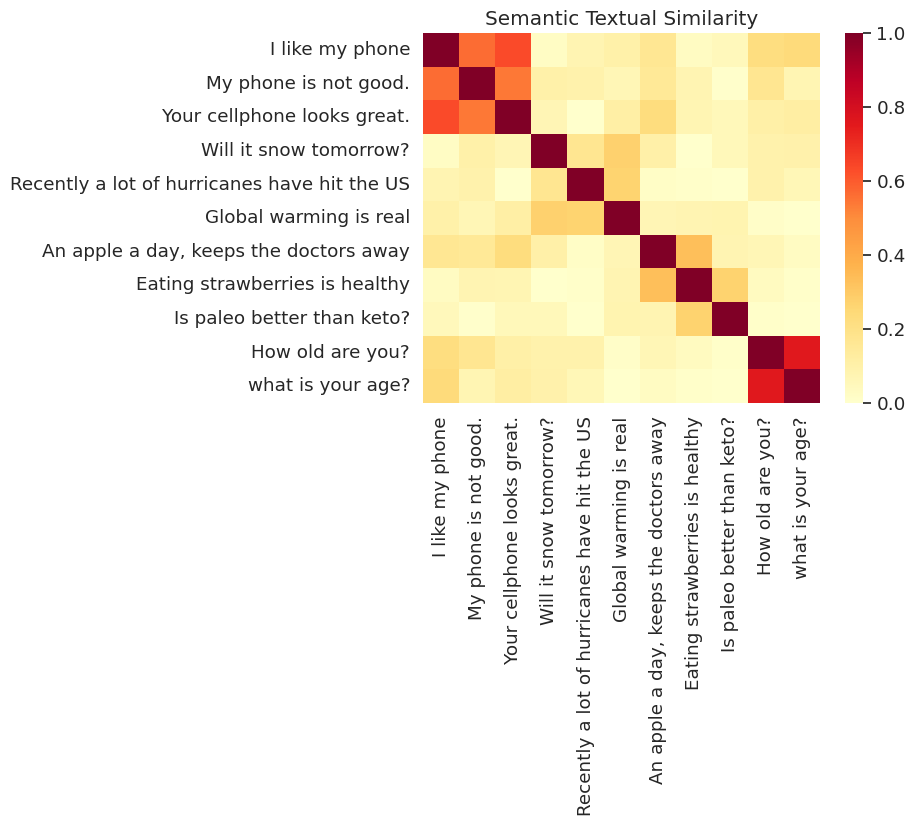

In [9]:
# Exemplo baseado em:
# https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


sent_emb = SentenceEmbeddings().sbert(sentences) #escolha o modelo de sentence embeddings de sua preferência
plot_similarity(sentences, sent_emb, 90)

## Modelagem e Extração de Conhecimento

### Agrupamento de Textos
- k-means
- Agrupamento Hierárquico
- Detecção de Comunidades em Grafos

### k-means
TBD

### Agrupamento Hierárquico
TBD

### Detecção de Comunidades em Grafos
TBD

### Modelagem de Tópicos

* Objetivo: identificar estruturas semânticas em um corpus
* Processo não supervisionado
* A ordem das palavras não importa, portanto podem ser usadas representações como o Bag of Words (BoW) ou Tf-Idf

#### Exemplos em um corpus de notícias

* delimitar diferentes eventos (e.g., confronto entre Rússia e Ucrânia, Copa do Mundo, etc.)
* identificar grandes temas (e.g., economia, política, educação, etc.)
* pautas de discussão (e.g., aborto, questões climáticas, combate ao crime, etc.)
* !!! Ou todos os casos acima misturados -- o que é comum de acontecer

#### Funcionamento de um modelo de tópicos

* cada documento pode ser representado por um histograma com a contagem de cada termo contido nele
* a forma desse histograma é proveniente de uma distribuição entre $k$ tópicos 
* os $k$ tópicos são distribuídos entre os termos no vocabulário do corpus

O objetivo da modelagem de tópicos, então, é aprender essas distribuições.

<img src="figs/topic-model.png" style="float: center; zoom:100%;" />

Fonte: https://pyro.ai/examples/prodlda.html

#### Técnicas para modelagem de tópicos

* Latent Dirichlet Allocation (LDA)
* Latent Semantic Analysis (LSA) ou LSI (redução dimencional)
* Probabilistic Semantic Analysis (pLSA) (versão probabilística do LSA)

#### Pré-processamento para modelagem de tópicos

* tentar preservar palavras que podem ser representativas para o domínio
* não é necessário preservar a sequência dos termos

#### Desafios

Obs: os exemplos a seguir são de tópicos identificados em um corpus de páginas web sobre as Eleições de 2018 no Brasil e Eleições de 2019 no Canadá.

* Muitas vezes os tópicos são difíceis de serem caracterizados, necessitando conhecimento específico de domínio
    * e.g. "battisti, pf, italiano, italia, grafico, recurso, utc, extradicao, moro, deus"
    * e.g. "pipeline, climate, oil, energy, fossil_fuel, carbon, france, kinsella, people_party, industry"
* As top N palavras de um tópico nem sempre delimitam claramente o assunto
    * e.g. "ex_presidente, ciro_gomes, ciro, artista, cunha, universidade, dilma, eduardo, classificar, reeleicao"
* O valor $k$ é escolhido manualmente
    * mesmo usando métricas como score de coerência e distribuição dos tópicos ao longo do corpus, ainda é necessário o julgamento humano da adequabilidade do valor $k$
* Tópico evoluem ao longo do tempo (para isso existem modelos temporais de tópicos)

#### Exemplo prático

Ao final deste notebook, colocamos um exemplo prático usando o LDA em um dataset de notícias sobre as eleições canadenses de 2019.

## Compreensão Semântica e Emocional


### Detecção de Intenção

<img src="figs/ir-example.png" style="float: center; zoom:100%;" />

## Detecção de intenção
- Uma intenção fornece uma interpretação geral do significado de uma expressão
- Normalmente, é uma tarefa abstraída em um processo de classificação
- Para isso, o primeiro passo é a obtenção de um conjunto de expressões rotuladas (*corpus*) para treinamento do modelo de classificação
- Como veremos a seguir, existem muitos *corpus* disponíveis publicamente para essa tarefa.
- Mas, caso deseje preparar o seu próprio *corpus* com dados de mídias sociais, você pode utilizar a modelagem de tópicos para determinar quais assuntos estão presentes no *corpus* e realizar a separação dos dados e, então, revisar e rotular manualmente cada um deles.

### Corpus
- Iremos considerar o conjunto de dados "Coronavirus tweets NLP - Text Classification", disponível na plataforma [Kaggle](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification)
- O dataset de treinamento é composto por **41157 tweets**, que foram manualmente rotulados em 5 categorias, sendo elas: **Positive, Negative, Neutral, Extremely Positive, Extremely Negative**

- Veja na Tabela a seguir mais detalhes sobre os dados:

<center> Tabela: Categorias e exemplos do conjunto de dados "Coronavirus tweets NLP - Text Classification". </center>

| Categoria | # (%) | Exemplo |
| --- | --- | --- |
| Positive | 11422 (27,75%) | We can't thank them enough!! #nhs #nurses #doctors #pharmacists #teachers #supermarket #delivery #thankyou #coronavirus #pealways #stamptheworld https://URL |
| Negative | 9917 (24,09%) | I can't even imagine working at a grocery store during this time. Props to all of you guys. I know I would be beyond annoyed at everyone #coronavirus #grocerystores |
| Neutral | 7713 (18,74%) | The biggest mall in my area is closed. Yet the store I work at is still open. ????? #coronavirus #Retail https://URL |
| Extremely Positive | 6624 (16,09%) | When someone gets closer than 6 ft at the grocery store. Hope you all are being safe and still having fun at home. We look forward to curing your cabin fever soon. #coronavirus |
| Extremely Negative | 5481 (13.71%) | Caught on cam A man likely infected with the spits on some packaged drinks at a grocery store in an attempt to infect as many as possible Their motto If I die you die with me |

### Modelo de Classificação de Intenções
<br>

<center>Redes Neurais Recorrentes (RNN) X Sentence Embeddings (imagem de [Feng et al. 2020])</center>

<img src="figs/bilstm-ir.png" style="float: left; zoom:60%;" />
<img src="figs/labse.png" style="float: right; zoom:60%;" />

In [27]:
# Ler o dataset e mostrar a quantidade de exemplos por categoria
coronanlp_train_data = pd.read_csv("data/Corona_NLP_train.csv", header=0, sep=",", index_col=False)
coronanlp_train_data["Sentiment"].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [30]:
# Pega uma amostra menor (10%) dos dados, para o treinamento ser mais rápido
sample = coronanlp_train_data.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(frac=0.1))
sample.shape


(4115, 6)

In [31]:
## Pre-processamento
sample["text"] = sample['OriginalTweet'].apply(pipeline.normalization)

re_links = r'https?:\/\/.*[\r\n]*'
apply_regex = lambda x: pipeline.clean_regex(x, re_links, value='LINK')
sample["text"] = sample["text"].apply(apply_regex)

re_mentions = r'@([A-Za-z0-9_]+)'
apply_regex = lambda x: pipeline.clean_regex(x, re_mentions, value='USERNAME')
sample["text"] = sample["text"].apply(apply_regex)

re_newline = '\\n'
apply_regex = lambda x: pipeline.clean_regex(x, re_newline)
sample["text"] = sample["text"].apply(apply_regex)

re_special_char = '\W+'
apply_regex = lambda x: pipeline.clean_regex(x, re_special_char)
sample["text"] = sample["text"].apply(apply_regex)

sample.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,text
2349,6148,51100,"England, United Kingdom",17-03-2020,@eBay_UK how are you allowing people to sell a...,Extremely Negative,USERNAME how are you allowing people...
29288,33087,78039,NaN,05-04-2020,"War on drugs, firing IG &amp; Capt CG-52? US l...",Extremely Negative,war on drugs firing ig amp capt ...
9844,13643,58595,London,20-03-2020,If I had a blue badge @Twitter account and the...,Extremely Negative,if i had a blue badge USERNAME a...
6637,10436,55388,Wolverhampton,19-03-2020,A pharmacy in the Black Country has come under...,Extremely Negative,a pharmacy in the black country ha...
41128,44927,89879,"Melbourne, Australia",14-04-2020,The COVID-19 pandemic and global oil price war...,Extremely Negative,the covid 19 pandemic and global o...


In [32]:
# Treinamento utilizando o LaBSE
intent_labse_model, X_test_labse, y_test_labse, classes = SemanticComprehension().training_intents("labse", sample["text"].tolist(), sample["Sentiment"].tolist())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4115/4115 [00:00<00:00, 3639721.84it/s]


Acurracy:  0.36509479824987845


In [34]:
#Treinamento com a RNN (BiLSTM + LSTM)
# Epochs = 20
# Batch size = 32
# Hidden layers = 300
# Max sequence length = 280 --> tweet size
intent_rnn_model, X_test_rnn, y_test_rnn, classes = SemanticComprehension().training_intents("rnn", sample["text"].tolist(), sample["Sentiment"].tolist())


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4115/4115 [00:00<00:00, 3679292.47it/s]
2022-11-03 19:39:52.336368: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-11-03 19:39:52.455301: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2899885000 Hz
2022-11-03 19:39:52.461008: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f78e0000b20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-03 19:39:52.461061: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


(4115, 280)
Train on 2058 samples, validate on 2057 samples
Epoch 1/20
2058/2058 [==============================] - 326s 158ms/step - loss: 1.5903 - accuracy: 0.2648 - val_loss: 1.5528 - val_accuracy: 0.2854
Epoch 2/20
2058/2058 [==============================] - 321s 156ms/step - loss: 1.4645 - accuracy: 0.3630 - val_loss: 1.5370 - val_accuracy: 0.3267
Epoch 3/20
2058/2058 [==============================] - 320s 155ms/step - loss: 1.1606 - accuracy: 0.5403 - val_loss: 1.5796 - val_accuracy: 0.3340
Epoch 4/20
2058/2058 [==============================] - 320s 156ms/step - loss: 0.8008 - accuracy: 0.6866 - val_loss: 1.5424 - val_accuracy: 0.3743
Epoch 5/20
2058/2058 [==============================] - 320s 155ms/step - loss: 0.5747 - accuracy: 0.7891 - val_loss: 1.7274 - val_accuracy: 0.3836
Epoch 6/20
2058/2058 [==============================] - 320s 156ms/step - loss: 0.3833 - accuracy: 0.8605 - val_loss: 2.1735 - val_accuracy: 0.3525
Epoch 7/20
2058/2058 [==============================

In [36]:
# LaBSE's performance
y_hat = intent_labse_model.predict(X_test_labse)
SemanticComprehension().plot_confusion_matrix(y_test_labse, y_hat, classes, "figs/ir-labse-cm.png")

# RNN's performance
y_hat = intent_rnn_model.predict(X_test_rnn)        
SemanticComprehension().plot_confusion_matrix(np.argmax(y_test_rnn,axis=1), np.argmax(y_hat, axis=1), classes, "figs/ir-rnn-cm.png")

### Matrix de Confusão
<br>

<center>Redes Neurais Recorrentes (RNN) X Sentence Embeddings</center>

<img src="figs/ir-rnn-cm.png" style="float: left; zoom:22%;" />
<img src="figs/ir-labse-cm.png" style="float: right; zoom:22%;" />

In [ ]:
# Predição de intents para os tweets coletados
intents = CompreensaoSemantica().predicao_intencoes(intent_labse_model, sentences) ## configurado apenas para o modelo LaBSE
intents.head()

### Reconhecimento de Entidades Nomeadas
TBD

### Corpus
- Iremos considerar o conjunto de dados disponível em  https://www.kaggle.com/code/amoghjrules/twitter-entity-recognition-using-bilstms
- abc

In [ ]:
entities = []
for sentence in tqdm(sentences):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(sentence)
    entity = {}
    for i, ent in enumerate(doc.ents):
        entity[i] = {
                        "value":ent.text,
                        "entity":ent.label_,
                        "start":ent.start_char,
                        "end":ent.end_char
                    }
    entities.append(entity)

print(entities[:3])

## Análise de Sentimentos (AS)

* Também conhecida como **Mineração de Opiniões**
* AS é o "estudo computacional das opiniões, atitudes e emoções de pessoas em relação a uma entidade" [Medhat et al. 2014]

### Tarefas de AS

* **Detecção de sentimento**
    - e.g. positivo, negativo ou neutro
* **Identificação de emoções**
    - e.g. sentimentos como raiva, antecipação, nojo, medo, alegria, tristeza, surpresa, confiança, etc. 
* **Detecção de toxicidade** 
    - e.g. categorias como insulto, profanidade, conteúdo sexualmente explícito, etc. [Jigsaw 2022]
* **Análise multilíngue de sentimentos**
* **Detecção de sarcasmo**
* etc.

### Exemplos de aplicações de AS

* Identificação de comentários agressivos em notícias [Jigsaw 2022]
* Extração da opinião pública sobre um candidato ou partido político [Pang et al. 2008]
* Priorização de respostas a avaliações negativas de produtos [Bougie et al. 2003] 
* etc.

### Vantages da AS

* Permite análises em larga escala
* Reduz a subjetividade provocada por avaliadores humanos

### Níveis da AS

1. **Nível de documento** - premissa: documento expressa opinião sobre apenas uma entidade; 
2. **Nível de frase** - premissa: frase expressa opinião sobre apenas uma entidade;  
3. **Nível de aspecto** - múltiplas opiniões sobre múltiplos aspectos (ou alvos)
    - e.g. “A <span style="color:#f00">qualidade de voz</span> deste telefone <span style="color:#f00">não é boa</span>, mas a <span style="color:#00f">vida útil da bateria</span> é <span style="color:#00f">longa</span>”

### Abordagens para criação de modelos de AS

1. **Usando Léxicos** 
    * <span style="color: #088B00">VANTAGEM</span>: independência de domínio
    * <span style="color: #f00">DESVANTAGEM</span>: menor precisão e baixa escalabilidade
2. **Aprendizado de máquina (ML)**
    * <span style="color: #088B00">VANTAGEM</span>: maior precisão
    * <span style="color: #f00">DESVANTAGEM</span>: maior dependência de domínio
3. **Híbrido (léxico + ML)** 

### A seguir iremos apresentar

* EmoLex
* LIWC
* Perspective API

In [ ]:
# Frases que vamos usar como exemplo para os modelos de AS

emotional_sentences = [

    # exemplo de frase positiva
    "How good it is to live in Curitiba!",

    # exemplo de frase neutra
    "This car is grey.",

    # exemplo de frase negativa
    "Shut up, you're an idiot!",

    # exemplo de frase negativa, mas com palavras que podem confundir o modelo de AS como "friend"
    "It must be so sad to have you as a friend"
]

### EmoLex

* Criado em 2013, é um dos maiores léxicos disponíveis em língua Inglesa
* Baseado em unigramas e bigramas dos léxicos
    * General Inquirer Lexicon
    * WordNet Affect Lexicon
* Anotações feitas via crowdsourcing pelo Mechanical Turk
* Associa palavras com as oito emoções da teoria de Plutchik [Plutchik 1980]
    * raiva, medo, antecipação, confiança, surpresa, tristeza, alegria e desgosto
* Também inclui as catergorias de sentimento negativo e positivo

In [ ]:
# Exemplo de sentenças processadas com o Emolex (frequência de emoções nas sentenças)
EmotionComprehension.emolex(emotional_sentences)

### LIWC

* Ferramenta para identificar características linguísticas, psicológicas e sociais em textos [Pennebaker et al. 2001]
* AS baseada em léxico (um dos maiores e mais completos na quantidade de termos e categorias cobertas)
* Léxicos separados para línguas diferentes, sendo o inglês a língua padrão
* Disponível apenas para Windows via interface gráfica

#### Categorias de conteúdo disponíveis no LIWC

* **emoções positivas** (e.g. amor, legal, doce, etc.)
* **emoções negativas** (e.g. ferido, feio, desagradável, etc.)
* **processos sociais** (e.g. filha, marido, vizinho, adulto, bebê, etc.)
* **processos cognitivos** (e.g. pensar, conhecer, causa, etc.)
* **processos perceptivos** (e.g. observar, escutar, sentir, etc.)
* **processos biológicos** (e.g. comer, sangue, dor, etc.)
* **relatividade** (e.g. chega, vai, embaixo, ontem, até, fim, etc.)
* **preocupações sociais** (e.g. auditar, igreja, cozinhar, trabalhar, mestrado, etc.)
* **consentimento** (e.g. concordar, ok, etc.)
* **não-fluências e palavras de preenchimento** (e.g. hm, er, umm, certo, etc.)
* entre outras [Tausczik and Pennebaker 2010]

#### Categorias de função disponíveis no LIWC

* **pronomes** 
* **preposições** 
* **artigos** 
* **conjunções** 
* **verbos auxiliares** 
* entre outras [Tausczik and Pennebaker 2010]

#### Interface do LIWC

<img src="figs/liwc.png" style="float: center; zoom:100%;" />

#### Exemplo de processamento com o LIWC

Para executar o processamento das sentenças de exemplo, será necessário [adquirir uma licença](https://www.liwc.app/buy), instalar o LIWC em um computador com Windows e processar o arquivo .csv gerado na célula a seguir. 

Você também poderá usar a versão de [teste online](https://www.liwc.app/demo), inserindo manualmente cada uma das sentenças geradas no .csv a seguir (essa versão é limitada a algumas poucas categorias, mas estão disponíveis as categorias de "Negative tone" e "Positive tone", bastante úteis em tarefas de AS). 

In [ ]:
# cria um .csv com exemplos para ser processado pelo LIWC
pd.DataFrame({'text': emotional_sentences}).to_csv('data/emotional_sentences_LIWC.csv', index=False)

In [ ]:
# carrega o arquivo com exemplos processado pelo LIWC
df_LIWC = pd.read_csv('emotional_sentences_LIWC.csv')

# apresenta apenas algumas colunas mais interessantes para AS
df_LIWC[['text', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad']]

### Perspective API

* Usado para identificação de toxicidade em comentários online
* Modelo multilíngue
* Disponibilizado gratuitamente por meio de uma iniciativa da Jigsaw, uma empresa da Google [Jigsaw 2022]
* Acessado via API pública
* Adotada pelos principais veículos jornalísticos internacionais para moderar comentários em seus portais

#### Desafios para identificar toxicidade em comentários

* Geralmente são textos curtos - ex.: “sei… 😏”, “¬¬”, “no way!”
* Uso de emojis ambíguos - ex.: 😏,🌚,😋 
* Erros de ortografia propositais (ou não) - ex.: “çocorro”;
* Gírias da internet - ex.: “vc”, “pq”, “lol”, “iti malia”
* Sutilezas inerentes à língua ou localidade - ex.: “oxi”, “p**ra!”;
* Especificidades de contexto - ex.: “ex-presidiário”, “bozo”;
* Uso de figuras de linguagem - ex.: metáfora, ironia, etc.;
* Susceptíveis a ataques adversários - ex.: “st.Up1d”
* Podem ocorrer de forma esparsa no conjunto de dados;

#### Definição de comentário tóxico

<center>"Um comentário rude, desrespeitoso ou irracional que provavelmente fará você sair de uma discussão."</center>

#### Funcionamento do Perspective API

* Atribui uma pontuação contínua entre 0 e 1 para diferentes categorias de toxicidade de acordo com o % no texto
* Uma pontuação mais alta para uma determinada categoria (ou atributo), indica uma maior probabilidade de um leitor perceber que o comentário possui este atributo
* e.g. “Você é um idiota” pode receber uma pontuação de $0.8$ para o atributo TOXICIDADE, indicando que 8 entre 10 pessoas perceberiam esse comentário como tóxico
* Portanto um comentário com pontuação de TOXICIDADE de $0.9$ não necessariamente é mais tóxico  que uma com $0.7$

 [Jigsaw 2022]

<img src="figs/perspective.png" style="float: center; zoom:100%;" />

Fonte: https://perspectiveapi.com/

#### Atributos de produção (multilíngue)

- **TOXICITY** - “Um comentário rude, desrespeitoso ou irracional que provavelmente fará com que as pessoas deixem uma discussão”; 
- **SEVERE_TOXICITY** - “Um comentário que é muito odioso, agressivo, desrespeitoso, ou muito provável de fazer um usuário sair de uma discussão, ou desistir de compartilhar sua perspectiva. Este atributo é muito menos sensível a formas mais leves de toxicidade, como comentários que incluem usos positivos de palavrões”; 
- **IDENTITY_ATTACK** - “Comentários negativos ou de ódio direcionados a alguém por causa de sua identidade”; 
- **INSULT** - “Comentário ofensivo, inflamatório ou negativo para uma pessoa ou grupo de pessoas”; 
- **PROFANITY** - “Xingamentos, palavrões ou outras linguagens obscenas, ou profanas”; 
- **THREAT** - “Descreve a intenção de infligir dor, lesão ou violência contra um indivíduo, ou grupo”.

#### Acessando o Perspective API

* Para executar os exemplos a seguir, você deverá solicitar acesso ao Perspective API no Google Cloud seguindo [esse passo a passo](https://developers.perspectiveapi.com/s/docs-get-started)
* Obtenha a chave da API para usar nos próximos passos

In [ ]:
# Credenciais do Perspective API

print("Informe seu 'API KEY'")
PERSPECTIVE_API_KEY = getpass.getpass()

In [ ]:
# Exemplo de sentenças processadas com o Perspective API
EmotionComprehension.perspective(emotional_sentences, PERSPECTIVE_API_KEY)

# <center>6. Aplicações</center>

## 6.1 Polarização Política

### Contextualização

* Artigo [Reaching the bubble may not be enough: news media role in online political polarization](https://epjdatascience.springeropen.com/articles/10.1140/epjds/s13688-022-00357-3)
* Autores
    * Jordan K. Kobellarz - UTFPR
    * Miloš Broćić - University of Toronto
    * Alexandre R. Graeml - UTFPR
    * Daniel Silver - University of Toronto
    * Thiago H. Silva- UTFPR 

#### Objetivo

Estudar o papel de intermediadores em cenários polarizados (Bubble Reachers)
    
<img src="figs/bubble-reachers.png" style="float: center; zoom:100%;" />

#### Situações estudadas

* Eleição presidencial brasileira de 2018
* Eleição federal canadense de 2019

#### Dados / Metodologia

1. Dados coletados usando a API de Streaming do Twitter
2. Identificação de polaridade dos usuários por meio de hashtags
3. Identificação dos top 100 Bubble Reachers por meio de uma métrica de centralidade chamada Intergroup Reaching
4. Extração de artigos em sites de notícias apontadas em tweets
5. Extração de entidades: (1) domínios | (2) conteúdos | (3) tópicos
6. Identificação da polaridade de cada entidade

#### Resultados

* Os Bubble Reachers mais representativos foram, em geral, contas de mídias de notícias neutras
* Mídias de notícias neutras são eficientes em contornar os filtros-bolha e distribuir conteúdos a grupos distintos na rede
* Mesmo sendo expostos a realidades distintas, usuários compartilham apenas conteúdos que reforçam seu viés
* O comportamento de compartilhamento depende mais do viés do conteúdo do que do tópico do conteúdo

#### A seguir

* Será apresentado um exemplo de extração de tópicos no dataset de notícias apontadas em tweets
* Iremos apresentar somente o caso Canadense por brevidade
* No final, será analisada a relação entre a polaridade dos tópicos e dos usuários que o retuitaram

### Análise e pré-processamento

#### Carregando os conjuntos de dados de notícias

* Notícias sobre as eleições canadenses de 2019
* Dataset em inglês

In [ ]:
def load_dataframe_from_drive_csv(url):
    path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
    return pd.read_csv(path)

# news dataset
url = 'https://drive.google.com/file/d/1AQjdqe9QRFK7ydNteZPM_IJk1eH-H3n_/view?usp=share_link'
df_news = load_dataframe_from_drive_csv(url)

# retweeted links dataset
url = 'https://drive.google.com/file/d/1Nn0I_tZnBWgUTNDeeE4bGzVTBhrTOJo1/view?usp=share_link'
df_retweeted_urls = load_dataframe_from_drive_csv(url)

#### Quantidade de notícias no conjunto de dados

In [ ]:
df_news.shape[0]

#### Exemplos de dados 

In [ ]:
pd.set_option('display.max_colwidth', 100)
df_news[['retweets_count', 'title', 'description', 'article']].sort_values('retweets_count', ascending=False)[:5]

#### Remoção de notícias duplicadas

In [ ]:
df_news = df_news.drop_duplicates(subset=['title', 'url'])

#### Combinação do título + descrição + corpo do artigo em uma única string

In [ ]:
df_news['text'] = df_news['title'].astype(str) + ' ' + df_news['description'].astype(str) + ' ' + df_news['article'].astype(str)

#### Estatísticas sobre o tamanho dos textos

* Textos longos (> 4500 caracteres em média)
* O menor texto tem 310 caracteres

In [ ]:
df_news['text_length'] = df_news['text'].apply(len)

In [ ]:
df_news['text_length'].describe()

#### Exemplos de notícias

* Escrita formal
* Sem erros de ortografia

In [ ]:
for content in df_news.sample(3)['text'].to_list():
    print(content[:500], '\n')

#### Pré-processamento dos textos

* Remoção de 
    * links 
    * caracteres isolados 
    * stop-words
* Lematização usando Spacy
* Transoformação em lowercase

In [ ]:
import unidecode
import re

# Instalação das dependências em inglês para a biblioteca Spacy
# python -m spacy download en_core_web_sm
spacy_nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Stopwords em inglês contidas na biblioteca Spacy
stop_words = list(spacy_nlp.Defaults.stop_words)

# Stopwords em inglês contidas na biblioteca do NLTK
stop_words += nltk.corpus.stopwords.words('english')

# Algumas outras palavras para serem removidas além das stop-words
stop_words += [
    '-pron-', 'video', 'try', 'refresh', 'continue', 'article', 'load', 'browser', 'say', 'will', 
    'would', 'content', 'news', 'sign', 'register', 'home', 'page', 'advertisement'
]


def preprocess(text):

    # Remoção de links 
    text = re.sub(r'http\S+', '', text)

    # Transforma o texto em um documento Spacy
    spacy_doc = spacy_nlp(text)

    # Usa o Spacy para lematizar o texto e remover stop words
    tokens = [token.lemma_.lower() for token in spacy_doc if token.lemma_.lower() not in stop_words]

    # Remove caracteres isolados
    tokens = [token for token in tokens if len(token) > 1]

    return tokens

In [ ]:
df_news['text'] = df_news['text'].apply(preprocess)

#### Exemplos de notícias pré-processadas

In [ ]:
df_news['text'][:10]

#### Frequência de termos mais representativos após o pré-processamento

In [ ]:
# Seta os padrões default para o matplot
plt.rcParams.update(plt.rcParamsDefault)

def get_all_terms(corpus):
    terms = []
    for text in corpus:
        terms = terms + text
    return terms


def term_frequency(corpus, num_plot=50, num_show=1000):
    plt.figure(figsize=(15, 5)) 

    terms = get_all_terms(corpus)
    fdist = nltk.FreqDist(terms)

    if num_plot > 0:
        fdist.plot(num_plot)

    # return a dataframe with terms and frequencies
    data = [[term, frequency] for term, frequency in fdist.most_common(num_show)]
    return pd.DataFrame(data, columns=['TERM', 'FREQUENCY'])

In [ ]:
df_terms = term_frequency(df_news['text'])

#### Geração de bi e trigramas

Usando o Gemsim para formar bi e trigramas caso os termos coocorram pelo menos 10 vezes:

In [ ]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models import CoherenceModel


def make_trigrams(corpus, min_count=5, threshold=10):

    # Criar os modelos de bi e trigramas

    # Obs.: quanto maior o threshold, menos N-gramas são formados
    bigram = Phrases(corpus, min_count=min_count, threshold=threshold)
    bigram_model = Phraser(bigram)

    trigram = Phrases(bigram[corpus], min_count=min_count, threshold=threshold)
    trigram_model = Phraser(trigram)

    return [trigram_model[bigram_model[text]] for text in corpus]

In [ ]:
df_news['text'] = make_trigrams(df_news['text'], 10)

#### Exemplos de notícias com bi e trigramas

In [ ]:
df_news['text']

#### Termos mais representativos após a identificação de bi e trigramas

In [ ]:
df_terms = term_frequency(df_news['text'])

#### Remoção de termos sem valor para o domínio

In [ ]:
for term in df_terms['TERM'].to_list():
    if len(term) > 15:
        print("'" + term + "',")

#### A partir da lista acima, são selecionados manualmente quais termos devem ser removidos

In [ ]:
unuseful_terms = [
    'apologize_fail_tap_team',
    'postmedia_network',
    'network_latest_national_stories',
    'soon_inbox_encounter_issue',
    'click_unsubscribe_link_email',
    'inc._365_bloor_street',
    'ontario_m4w_3l4_416',
    'thank_welcome_email_way',
    'check_junk_folder_issue',
    'story_midday_sun_newsroom',
    'inbox_noon_late_headline',
    'story_opinion_photo_toronto',
    'sun_email_address_error',
    'provide_valid_email_address',
    'click_button_consent_receive',
    'newsletter_postmedia_network_inc.',
    'unsubscribe_time',
    'original_archive'
]

def remove_unuseful_terms(text):
    return [token for token in text if token.lower() not in unuseful_terms]

df_news['text'] = df_news['text'].apply(remove_unuseful_terms)

## Identificação de tópicos com LDA

Referência: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

#### Criação do dicionário e corpus para o LDA usando o modelo BoW

In [ ]:
from gensim.corpora.dictionary import Dictionary

# Cria o dicionário a partir do corpus
gs_dictionary = Dictionary(df_news['text'])

# Remove os tokens muito raros (menos frequentes que `no_below`) ou muito comuns (mais frequentes que `no_above`%)
gs_dictionary.filter_extremes(no_below=3, no_above=.20)

# Cria o corpus usando o modelo de Bag of Words
gs_corpus = [gs_dictionary.doc2bow(text) for text in df_news['text'].to_list()]

In [ ]:
print('Dictionary size:', len(gs_dictionary), ', corpus size:', len(gs_corpus))

In [ ]:

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic %d:" % (topic_idx)
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

#### Treinamento de modelos LDA 

* Para treinar os modelos LDA usamos diferentes valores para $k$ 
* Nesse tutorial, escolhemos $k=10$ até $k=30$, uma vez que temos aprox. 500 documentos no corpus
* Para cada modelo geramos o score de coerência e perplexidade, que são analisados a seguir

In [ ]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel


def compute_lda_performance(dictionary, corpus, texts, start=1, limit=50, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    perplexity_values : Perplexity values corresponding to the LDA model with respective number of topics
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    num_topics_values = []
    perplexity_values = []
    coherence_values = []
    for num_topics in range(start, limit+step, step):
        num_topics_values.append(num_topics)

        model = LdaMulticore(corpus=corpus, num_topics=num_topics, iterations=1000, id2word=dictionary, passes=10, random_state=100) 

        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence = coherencemodel.get_coherence()
        coherence_values.append(coherence)

        perplexity = model.log_perplexity(corpus)
        perplexity_values.append(perplexity)

        print('Topics:', num_topics, '\tPerplexity:', round(perplexity, 5), '\tCoherence:', round(coherence, 5))

    df_results = pd.DataFrame({'topics': num_topics_values, 'perplexity': perplexity_values, 'coherence': coherence_values})
    return df_results

In [ ]:
df_lda_models = compute_lda_performance(dictionary=gs_dictionary, corpus=gs_corpus, texts=df_news['text'], start=10, limit=30, step=2)

#### Análise do score de coerência

* Indica o quão "interpretável" são os tópicos para humanos
* Indica o quanto as palavras mais representativas de cada tópico são similares entre si
* Diferentes medidas de similaridade podem ser usadas, a padrão é o score c_v, que usa similaridade do cosseno
* Heurística: quanto maior o score de coerência, melhor (mas nem sempre)
    * Usar método do "cotovelo"
    * Analisar o gráfico de tópicos (a seguir)
    * Usar bom senso

In [ ]:
# Scores de coerência de acordo com o número de tópicos
ax = df_lda_models.plot.line(x='topics', y='coherence')
ax.set_xlabel("Num Topics")
ax.set_ylabel("Coherence")

In [ ]:
# Top 5 modelos
df_lda_models.sort_values('coherence', ascending=False)[:5]

#### Identifica o melhor número de tópicos de acordo com o score de coerência

In [ ]:
best_num_topics = df_lda_models.sort_values('coherence', ascending=False)['topics'].tolist()[0]

best_num_topics

#### Treinamento do modelo com o melhor número de tópicos 

Aqui repetimos o treinamento do modelo com o melhor número de tópicos usando uma quantidade maior de iterações e passes no dataset.

In [ ]:
lda = LdaMulticore(corpus=gs_corpus, num_topics=best_num_topics, 
                   iterations=10000, id2word=gs_dictionary, passes=100, 
                   random_state=100)

#### Coerência e perplexidade do modelo final

In [ ]:
# Compute Perplexity (lower is better)
print('\nPerplexity: ', lda.log_perplexity(gs_corpus)) 

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=df_news['text'], 
                                     dictionary=gs_dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())

#### Palavras mais representativas de cada tópico

Alguns exemplos de tópicos:

* **IMPOSTO DE CARBONO:** carbon_tax, emission, climate_change, tax, cbc, economy, cent, target, cost, program 
* **ABORTO:** abortion, debate, harper, comment, conservative_party, sex_marriage, law, view, conservative_leader, montreal 
* **PESQUISA ELEITORAL:** poll, mr._scheer, cent, mr._trudeau, survey, research, 30, age, positive, centre 
* **CORTE ORÇAMENTÁRIO:** billion, cut, platform, million, city, toronto, tax, bernier, budget, spending 
* **CASO DE RACISMO:** blackface, racist, apologize, black, apology, rcmp, woman, racism, global, makeup 
* **PETRÓLEO:** pipeline, oil, climate_change, climate, company, energy, encana, coal, spend, money 
* **IMIGRAÇÃO:** insurance, claim, refugee, comment, act, facebook, immigrant, immigration, insurance_broker, anti 

In [ ]:
for i, topic in enumerate(lda.top_topics(topn=5, texts=df_news['text'])):
    terms = topic[0]
    print('Topic', i, ', '.join([term[1] for term in terms]))

#### Visualização dos tópicos

* Cada bolha representa um tópico. Quanto maior a bolha, mais prevalente é esse tópico.
* Um bom modelo de tópico terá bolhas grandes e não sobrepostas espalhadas por todo o gráfico.
* Um modelo com muitos tópicos normalmente terá muitas sobreposições, bolhas de tamanho pequeno agrupadas em uma região do gráfico.

Fonte: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python

In [ ]:
import warnings
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

def show_lda_vis(lda, gs_corpus, gs_dictionary):
    # Workaround para evitar que o pyLDAvis esconda os botões do Jupyterlab
    from IPython.display import HTML
    css_str = '<style> \
    .jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
    .bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
    .jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
    text.terms { fill: #616161;} \
    </style>'
    display(HTML(css_str))

    # feed the LDA model into the pyLDAvis instance
    warnings.filterwarnings('ignore')
    return gensimvis.prepare(lda, gs_corpus, gs_dictionary)

In [ ]:
show_lda_vis(lda, gs_corpus, gs_dictionary)

#### Salva os 3 tópicos mais representativos de cada notícia no dataframe

In [ ]:
topic_2_words = {}
for topic in lda.show_topics(num_topics=100, num_words=10, formatted=False):
    topic_id = topic[0]
    topic_tokens = ', '.join([token[0] for token in topic[1]])
    topic_2_words[topic_id] = topic_tokens

In [ ]:
doc_topics_1 = []
doc_topics_1_words = []
doc_topics_1_percentages = []

doc_topics_2 = []
doc_topics_2_words = []
doc_topics_2_percentages = []

doc_topics_3 = []
doc_topics_3_words = []
doc_topics_3_percentages = []

for i, doc in enumerate(df_news['text'].to_list()):
    doc_bow = gs_dictionary.doc2bow(doc)
    
    # get document topics (each row contains a tuple with topic id and topic probability)
    doc_topics = lda.get_document_topics(doc_bow)
    
    # sort topics by probability
    doc_topics.sort(key=lambda x:x[1], reverse=True)
    
    # get them main topic and top 3 topics
    topics = doc_topics[:3]
    
    if len(topics) > 0:
        doc_topics_1_percentages.append(topics[0][1])
        topic_id = topics[0][0]
        doc_topics_1.append(topic_id)
        doc_topics_1_words.append(topic_2_words[topic_id])
    else:
        doc_topics_1.append(None)
        doc_topics_1_percentages.append(None)
        doc_topics_1_words.append(None)
        
        
    if len(topics) > 1:
        doc_topics_2_percentages.append(topics[1][1])
        topic_id = topics[1][0]
        doc_topics_2.append(topic_id)
        doc_topics_2_words.append(topic_2_words[topic_id])
    else:
        doc_topics_2.append(None)
        doc_topics_2_percentages.append(None)
        doc_topics_2_words.append(None)
        
        
    if len(topics) > 2:
        doc_topics_3_percentages.append(topics[2][1])
        topic_id = topics[2][0]
        doc_topics_3.append(topic_id)
        doc_topics_3_words.append(topic_2_words[topic_id])
    else:
        doc_topics_3.append(None)
        doc_topics_3_percentages.append(None)
        doc_topics_3_words.append(None)

In [ ]:
df_news['topic'] = pd.Series(doc_topics_1)
df_news['topic_words'] = pd.Series(doc_topics_1_words)
df_news['topic_percentage'] = pd.Series(doc_topics_1_percentages)

df_news['topic_1'] = pd.Series(doc_topics_1)
df_news['topic_1_words'] = pd.Series(doc_topics_1_words)
df_news['topic_1_percentage'] = pd.Series(doc_topics_1_percentages)

df_news['topic_2'] = pd.Series(doc_topics_2)
df_news['topic_2_words'] = pd.Series(doc_topics_2_words)
df_news['topic_2_percentage'] = pd.Series(doc_topics_2_percentages)

df_news['topic_3'] = pd.Series(doc_topics_3)
df_news['topic_3_words'] = pd.Series(doc_topics_3_words)
df_news['topic_3_percentage'] = pd.Series(doc_topics_3_percentages)

#### Distribuição dos tópicos mais representativos em cada notícia

* O tópico mais representativo (em azul) tem alta dominância para a maioria das notícias
* O segundo e terceiro tópicos mais representativos, em laranja e verde, tem uma representatividade baixa na maioria das notícias em comparação com o azul. 

In [ ]:
ax1 = pd.Series(doc_topics_1_percentages).plot.hist(bins=25)
ax2 = pd.Series(doc_topics_2_percentages).plot.hist(bins=25)
ax3 = pd.Series(doc_topics_3_percentages).plot.hist(bins=25)

#### Distribuição dos tópicos mais dominantes entre as notícias

In [ ]:
df = df_news.groupby('topic_1').agg({
    'article': 'count'
}).reset_index().rename(columns={
    'topic_1': 'dominant topic id',
    'article': 'number of news',
}).sort_values('number of news', ascending=False)

df['dominant topic id'] = df['dominant topic id'].astype('int')

ax = df.plot.bar(x='dominant topic id', y='number of news', figsize=(15,3))

In [ ]:
df['number of news'].describe()

#### Exemplos de manchetes em 5 tópicos

In [ ]:
for i in range(0, 5):
    print('\nTopic', i)
    print(df_news[df_news['topic'] == i]['title'][:5])

In [ ]:
def get_topic_1(url):
    df = df_news[df_news['url'] == url]
    return df.iloc[0]['topic'] if df.shape[0] == 1 else None

def get_topic_1_words(url):
    df = df_news[df_news['url'] == url]
    return df.iloc[0]['topic_words'] if df.shape[0] == 1 else None

df_retweeted_urls['topic'] = df_retweeted_urls['retweeted_url'].apply(get_topic_1)
df_retweeted_urls['topic_words'] = df_retweeted_urls['retweeted_url'].apply(get_topic_1_words)

### Resultados

Heatmap de tópicos vs retweets de usuários por faixa de polaridade

In [ ]:
%matplotlib inline

def relative_polarity_heatmap(df, column, oversample=True, title=None, x_label=None, y_label_left=None, y_label_right=None, 
                              cbar_label=None, top_n=20, vmax=1, numeric_index=False, only_dataframe=False):
    
    env_polarities = [value/10 for value in range(-10,11,1)]
    
    df_copy = df.copy()    
    
    """
    -------------------
    RP(H) calculation
    -------------------
    """

    # generate a matrix with rows being 'column' parameter values and columns being polarities from -1 to +1
    df = pd.crosstab(index=df[column], columns=df['user_P(H)_bin'], values=df[column], aggfunc='count')
    df = df.fillna(0.0)
    
    # add faulting columns (for faulting polarities)
    for polarity in env_polarities:
        if not polarity in df.columns:
            num_rows = df.shape[0]
            df[polarity] = pd.Series([0.0] * num_rows)
            
    # reorder columns from -1.0 to +1.0
    df = df[env_polarities]
    
    # scale by dividing the retweets count of each polarity for each domain by the max retweets count of each polarity from all domains
    if oversample:
        df_polarity_max_retweets = df.max(axis=0) # get polarity column max value
        for polarity in env_polarities:
            df[polarity] = df[polarity] / df_polarity_max_retweets[polarity]    
    
    # normalize values to 0-1 interval with min-max (by domain min-max from all polarities)
    max_df = df.max(axis=1)
    min_df = df.min(axis=1)
    for polarity in env_polarities:
        df[polarity] = (df[polarity] - min_df) / (max_df - min_df) 
       
    # calculate polarity average without zeros and neutral users count
    relative_polarities = []
    for i, row in df.iterrows():
        row_sum = 0
        count = 0
        for polarity in env_polarities:
            if polarity != 0.0 and row[polarity] > 0.0: # only count cells with non zero value and remove the neutral polarity
                row_sum += row[polarity] * polarity
                count += row[polarity]
        if count > 0:
            relative_polarities.append(row_sum / count)
        else:
            relative_polarities.append(None)
        
    df['relative_polarity'] = relative_polarities
    
    
    """
    -------------------
    Data preparation
    -------------------
    """
    
    # count occurrences of 'column' values
    df_rphs = df_copy.groupby(column).agg(
        retweets_count=pd.NamedAgg(column=column, aggfunc='count')
    ).sort_values(by=column, ascending=False)
    df_rphs[column] = df.sort_index(ascending=False).index
    df_rphs['RP(H)'] = df.sort_index(ascending=False)['relative_polarity']
    
    """
    -------------------
    Data visualization
    -------------------
    """
    
    if not only_dataframe:
    
        # get only top N most retweeted 'column' values to include in the heatmap
        if top_n:        
            top_column_values = df_rphs.sort_values(by='retweets_count', ascending=False)[:top_n][column].unique()
            df = df[df.index.isin(top_column_values)]

        # sort heatmap rows by relative_polarity values
        df = df.sort_values('relative_polarity')
        relative_polarities = df['relative_polarity'].map('{:,.2f}'.format).astype('str').to_list()
        
        # drop relative_polarity to not include in the heatmap
        df = df.drop(columns=['relative_polarity'])
        df = df.fillna(0.0)        
            
        # get a print friendly datatable
        row_indexes = list(range(1,len(df.index)+1))
        row_values = df.index        
        df_heatmap_table = pd.DataFrame({'ID': row_indexes, y_label_left: row_values, 'RP(H)': relative_polarities})
        
        # create a sequential numeric 'id' for heatmap rows
        if numeric_index:            
            df['id'] = row_indexes
            df = df.set_index('id')

        plt.subplots(figsize=(2,round(top_n/3.5)))
        ax = sns.heatmap(df, annot=False, linewidths=.1, robust=True, cmap='YlOrBr', vmin=0, vmax=vmax, cbar=False, square=True)
        ax.set_title(title or '')
        ax.set_xlabel(x_label or 'User P(H)')
        ax.set_ylabel(y_label_left or '')
        #ax.collections[0].colorbar.set_label(cbar_label or 'Retweet density')
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
        ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)

        # maintain only 5 tick labels to simplify
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n not in [0, 5, 10, 15, 20]:
                label.set_visible(False)

        # add right y axis
        ax2 = ax.twinx() # share x-axis
        ax2.set_ylabel(y_label_right or '')
        ax2.tick_params(right=True, pad=6)
        ax2.set_aspect('auto', share=True, )
        ax2.set_ylim((top_n, 0))
        ax2.set_yticks(ax.get_yticks())
        ax2.set_yticklabels(relative_polarities)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.spines['left'].set_visible(False)

        fig = ax.get_figure()
        fig.set_size_inches(2, round(top_n/3.5))

    return df_rphs, df_heatmap_table, fig

In [ ]:
warnings.filterwarnings('ignore')
df, df_heatmap, fig = relative_polarity_heatmap(
    df=df_retweeted_urls, column='topic_words', y_label_left='Tópico', 
    y_label_right='Polaridade do tópico', x_label='Polaridade dos usuários',
    top_n=10
)